In [1]:
from scikeras.wrappers import KerasClassifier 
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from keras.callbacks import Callback
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, SimpleRNN, Reshape, GRU, Dropout, BatchNormalization, Attention, Dot
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, mean_squared_error
from imblearn.over_sampling import SMOTE

In [2]:
folder_path = 'C:\\Users\\Administrator\\Documents\\TA\\dataset_feature_extracted\\'

Delete NaN Row

Test Train Split

In [3]:
record_names = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']

dfs = []

for record_name in record_names:
    df = pd.read_csv(f'C:\\Users\\Administrator\\Documents\\TA\\dataset_feature_extracted\\{record_name}_new.csv')
    dfs.append(df)

    # unique_labels = df.iloc[:, -1].unique()
    # print(record_name, unique_labels)

# Gabungkan DataFrame menjadi satu DataFrame tunggal
combined_df = pd.concat(dfs, ignore_index=True)
combined_df = combined_df[~combined_df['Label'].str.contains('[\+Q!EJf\"~a]')]

# Cetak hasilnya
print(combined_df)

     Label  Min RR  Max RR      AVG RR  Median RR   Skew RR  Kurtosis RR  \
0        A     275     331  295.608696      295.0  1.053874     0.839279   
1        N     265     324  293.458333      294.5  0.045407     0.182541   
2        N     275     306  291.956522      290.0  0.091653    -0.940913   
3        N     278     309  291.583333      291.5  0.148143    -0.898717   
4        N     277     311  292.083333      289.5  0.444330    -0.777377   
...    ...     ...     ...         ...        ...       ...          ...   
4363     N     227     260  242.586207      243.0  0.204324    -0.258361   
4364     N     227     306  240.310345      238.0  3.623050    14.650541   
4365     N     229     251  242.586207      243.0 -0.817607     0.006916   
4366     N     235     291  246.000000      241.5  2.285232     5.352454   
4367     N     235     292  251.166667      244.0  1.506415     0.694636   

      Min PR  Max PR     AVG PR  ...     AVG QT  Median QT   Skew QT  \
0         37   

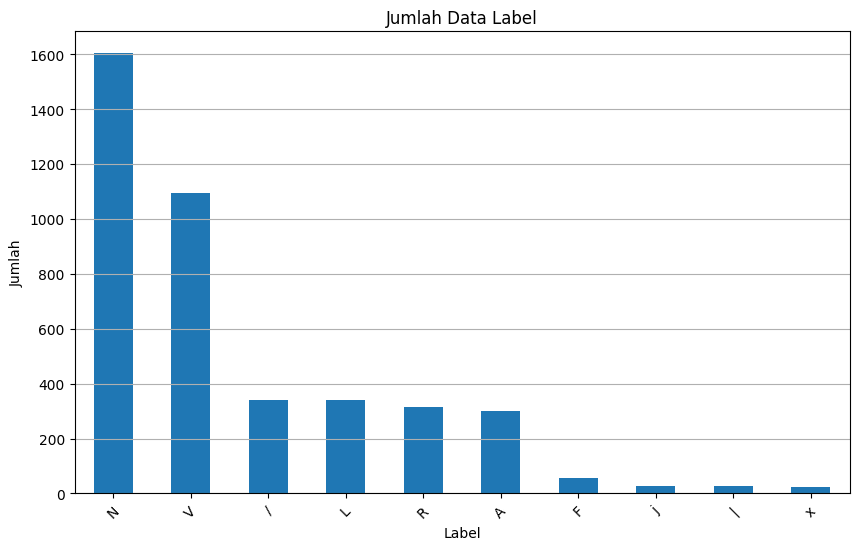

In [4]:
# Hitung jumlah kemunculan setiap nilai di kolom 'Label'
label_counts = combined_df['Label'].value_counts()

# Plot bar chart jumlah data label
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Jumlah Data Label')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [5]:
combined_df.isna().sum()

Label           0
Min RR          0
Max RR          0
AVG RR          0
Median RR       0
Skew RR         0
Kurtosis RR     0
Min PR          0
Max PR          0
AVG PR          0
Median PR       0
Skew PR         0
Kurtosis PR     0
Min QT          0
Max QT          0
AVG QT          0
Median QT       0
Skew QT         0
Kurtosis QT     0
Min QRS         0
Max QRS         0
AVG QRS         0
Median QRS      0
Skew QRS        0
Kurtosis QRS    0
dtype: int64

In [6]:
with open("C:\\Users\\Administrator\\Documents\\my TA model\\combined_df.pkl", "wb") as f:
    pickle.dump(combined_df, f)

Split Train and Test Phase

In [7]:
y = combined_df['Label']
X = combined_df.drop(columns=['Label'])

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)
y

array([1, 4, 4, ..., 4, 4, 4])

In [9]:
# Menghitung banyaknya masing-masing label
label_counts = np.bincount(y)

# Menampilkan hasil
for label, count in enumerate(label_counts):
    print(f'Label {label}: {count} occurrences')

Label 0: 342 occurrences
Label 1: 302 occurrences
Label 2: 58 occurrences
Label 3: 339 occurrences
Label 4: 1603 occurrences
Label 5: 315 occurrences
Label 6: 1094 occurrences
Label 7: 27 occurrences
Label 8: 22 occurrences
Label 9: 26 occurrences


In [9]:
for i in range(19):
    print(i, "=", le.inverse_transform([i]))

0 = ['/']
1 = ['A']
2 = ['F']
3 = ['L']
4 = ['N']
5 = ['R']
6 = ['V']
7 = ['j']
8 = ['x']
9 = ['|']


ValueError: y contains previously unseen labels: [10]

In [10]:
sm = SMOTE(random_state=42)
X_resampling, y_resampling = sm.fit_resample(X, y)

In [11]:
with open("C:\\Users\\Administrator\\Documents\\my TA model\\X_resampling.pkl", "wb") as f:
    pickle.dump(X_resampling, f)

In [12]:
with open("C:\\Users\\Administrator\\Documents\\my TA model\\y_resampling.pkl", "wb") as f:
    pickle.dump(y_resampling, f)

In [11]:
# Menghitung banyaknya masing-masing label
label_counts = np.bincount(y_resampling)

# Menampilkan hasil
for label, count in enumerate(label_counts):
    print(f'Label {label}: {count} occurrences')

Label 0: 1603 occurrences
Label 1: 1603 occurrences
Label 2: 1603 occurrences
Label 3: 1603 occurrences
Label 4: 1603 occurrences
Label 5: 1603 occurrences
Label 6: 1603 occurrences
Label 7: 1603 occurrences
Label 8: 1603 occurrences
Label 9: 1603 occurrences


In [12]:
X_resampling.head()

,Min RR,Max RR,AVG RR,Median RR,Skew RR,Kurtosis RR,Min PR,Max PR,AVG PR,Median PR,...,AVG QT,Median QT,Skew QT,Kurtosis QT,Min QRS,Max QRS,AVG QRS,Median QRS,Skew QRS,Kurtosis QRS
0,275,331,295.608696,295.0,1.053874,0.839279,37,66,57.416667,60.0,...,75.565217,76.0,-0.920519,1.915276,0.038889,0.172222,0.077778,0.044444,1.067616,-0.804765
1,265,324,293.458333,294.5,0.045407,0.182541,49,68,60.125000,61.0,...,77.333333,77.5,-0.735734,1.001693,0.063889,0.205556,0.166782,0.169444,-1.799679,3.875787
2,275,306,291.956522,290.0,0.091653,-0.940913,50,68,59.208333,60.0,...,80.695652,80.0,0.467175,-0.712123,0.166667,0.216667,0.183575,0.180556,0.704172,-0.613661
3,278,309,291.583333,291.5,0.148143,-0.898717,47,66,54.200000,52.0,...,80.791667,80.5,0.625572,0.783684,0.041667,0.061111,0.045139,0.044444,1.822580,3.497428
4,277,311,292.083333,289.5,0.444330,-0.777377,54,63,59.120000,60.0,...,79.333333,78.0,0.429184,-0.637050,0.163889,0.211111,0.179630,0.177778,0.763258,-0.382609


In [13]:
# min_max_scaler = MinMaxScaler()
# X_resampling = pd.DataFrame(min_max_scaler.fit_transform(X_resampling), columns=X_resampling.columns)

standard_scaler = StandardScaler()
fit_scaler = standard_scaler.fit_transform(X_resampling)
X_resampling = pd.DataFrame(fit_scaler, columns=X_resampling.columns)

In [16]:
with open("C:\\Users\\Administrator\\Documents\\my TA model\\standard_scaler.pkl", "wb") as f:
    pickle.dump(standard_scaler, f)

In [14]:
X_resampling.head()

,Min RR,Max RR,AVG RR,Median RR,Skew RR,Kurtosis RR,Min PR,Max PR,AVG PR,Median PR,...,AVG QT,Median QT,Skew QT,Kurtosis QT,Min QRS,Max QRS,AVG QRS,Median QRS,Skew QRS,Kurtosis QRS
0,1.440962,-0.428245,0.213358,0.252465,0.621199,-0.254825,-0.820873,-0.867825,-0.313446,0.064650,...,-0.673102,-0.510255,-1.164942,0.368511,-0.460404,-0.039106,-0.283845,-1.045518,-0.175504,-0.893349
1,1.275812,-0.479794,0.176762,0.244471,-0.065344,-0.400687,0.311138,-0.765590,-0.058651,0.160174,...,-0.567291,-0.429550,-0.991193,0.001942,0.582387,0.370824,2.637279,2.706099,-2.175211,0.040949
2,1.440962,-0.612348,0.151203,0.172527,-0.033860,-0.650206,0.405473,-0.765590,-0.144890,0.064650,...,-0.366075,-0.295041,0.139871,-0.685715,4.869415,0.507467,3.188407,3.039576,-0.428976,-0.855202
3,1.490507,-0.590256,0.144851,0.196509,0.004597,-0.640835,0.122470,-0.867825,-0.616065,-0.699547,...,-0.360329,-0.268139,0.288807,-0.085532,-0.344538,-1.405539,-1.355051,-1.045518,0.351024,-0.034576
4,1.473992,-0.575528,0.153361,0.164534,0.206234,-0.613885,0.782810,-1.021178,-0.153200,0.064650,...,-0.447602,-0.402648,0.104150,-0.655592,4.753549,0.439146,3.058924,2.956207,-0.387768,-0.809081


In [20]:
# pca = PCA(n_components=10)
# pca.fit(X_resampling)

# # Ambil nilai bobot dari komponen utama
# components = pca.components_

# # Buat DataFrame untuk menyimpan bobot fitur
# weights_df = pd.DataFrame(components, columns=X_resampling.columns)

# # Urutkan bobot fitur secara absolut untuk setiap komponen utama
# sorted_weights = weights_df.abs().apply(lambda x: x.sort_values(ascending=False), axis=1)

# # Ambil 10 fitur dengan bobot tertinggi untuk setiap komponen utama
# selected_features = sorted_weights.columns[:10]

# print("Fitur yang dipilih oleh PCA:")
# print(selected_features)

Fitur yang dipilih oleh PCA:
Index(['AVG PR', 'AVG QRS', 'AVG QT', 'AVG RR', 'Kurtosis PR', 'Kurtosis QRS',
       'Kurtosis QT', 'Kurtosis RR', 'Max PR', 'Max QRS'],
      dtype='object')


In [21]:
# X_resampling_pca = pca.transform(X_resampling)
# X_resampling_pca = pd.DataFrame(data=X_resampling_pca, index=X_resampling.index)

In [22]:
# X_resampling_pca

,0,1,2,3,4,5,6,7,8,9
0,-1.562837,-0.617270,0.616975,-0.984690,1.529481,-0.012038,0.167607,0.074061,1.385024,-0.901185
1,1.095865,-1.809252,3.771010,-0.736403,0.270991,-0.834469,-1.620515,0.216505,1.109686,-0.130130
2,2.217271,-0.766841,5.795103,-0.098059,0.094965,-0.426191,-1.514342,-1.143228,-1.386493,0.092357
3,-1.392417,-0.033028,0.008724,-0.807513,1.226822,0.324355,2.179622,-0.263136,-0.179965,-0.561200
4,2.090377,-0.749274,5.778603,-0.196573,0.626228,-0.476840,-1.459100,-1.118373,-1.268700,0.213275
...,...,...,...,...,...,...,...,...,...,...
16025,1.923350,-1.230012,-1.673154,0.167080,0.699483,-1.744692,0.748397,0.123321,0.448045,1.006986
16026,-0.162533,0.725162,2.283477,0.473658,0.877206,-0.373180,0.484630,-1.266217,-0.038690,1.039003
16027,0.771981,-1.901769,-0.315354,2.010842,-1.477623,-0.990313,-0.700955,0.320564,-0.164427,-0.439355
16028,0.350220,-0.725456,-1.349012,-1.023817,-0.519131,-1.701007,-0.273638,0.214664,0.512055,0.538060


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_resampling, y_resampling, test_size=0.2, random_state=42)

In [27]:
with open("C:\\Users\\Administrator\\Documents\\my TA model\\X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)

with open("C:\\Users\\Administrator\\Documents\\my TA model\\X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open("C:\\Users\\Administrator\\Documents\\my TA model\\y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

with open("C:\\Users\\Administrator\\Documents\\my TA model\\y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

Classification Phase

In [16]:
num_classes = 10
input_shape = (24, 1)
class_labels = ['/', 'A', 'F', 'L', 'N', 'R', 'V', 'j', 'x', '|']
# epochs = 20
# batch_size = 32

In [17]:
def plot_training_history(history):
    # Plot training history
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

#1 CLSTM

In [19]:
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional layers for feature extraction
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Add a Dense layer before LSTM for additional complexity
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Reshape the output to 2D
    model.add(Reshape((-1, model.output_shape[-1])))

    # LSTM layers for sequence modeling
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(128))
    model.add(Dropout(0.5))

    # Flatten the output after the last LSTM layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with adjusted learning rate
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


#2 CGRU

In [17]:
def create_cnn_gru_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional layers for feature extraction
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Add a Dense layer before GRU for additional complexity
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Reshape the output to 2D
    model.add(Reshape((-1, model.output_shape[-1])))

    # GRU layers for sequence modeling
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(GRU(128))
    model.add(Dropout(0.5))

    # Flatten the output after the last GRU layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with adjusted learning rate
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


#4 CAttention

In [18]:
def create_cnn_attention_gru_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional layers for feature extraction
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128 * 2, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Reshape the output to 2D
    model.add(Reshape((-1, model.output_shape[-1])))

    # Split the output into query and value
    query_value = Dense(32, activation='relu')(model.output)

    # Attention layer (manual implementation)
    query = Dense(32, activation='relu')(query_value)
    value = Dense(32, activation='relu')(query_value)
    attention_scores = Attention()([query, value])

    # Weighted sum of value using attention scores
    attended_value = Dot(axes=(1, 1))([attention_scores, value])

    # GRU layers for sequence modeling
    gru_output = GRU(128, return_sequences=True)(attended_value)
    gru_output = GRU(128, return_sequences=True)(gru_output)
    gru_output = GRU(128)(gru_output)

    # Output layer
    output = Dense(num_classes, activation='softmax')(gru_output)

    # Create the model
    model = Model(inputs=model.input, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

Default

#1 CAttention

In [19]:
# Fungsi untuk melakukan K-fold cross-validation
def k_fold_cross_validation(X, y, k=5, epochs=50, batch_size=64):
    # Inisialisasi KFold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Daftar untuk menyimpan model pada setiap fold
    models = []
    
    # Loop melalui setiap fold
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        print(f'Fold {fold}')
        
        # Split data menjadi data latih dan data validasi
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Inisialisasi model
        model = create_cnn_attention_gru_model(input_shape=input_shape, num_classes=num_classes)
        
        # Latih model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=2)
        
        plot_training_history(history)
        
        # Evaluasi model pada data validasi
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        print(f'Validation Accuracy: {accuracy}')
        
        # Tambahkan model ke dalam daftar
        models.append(model)
        
        print()
    
    return models


Fold 1
Epoch 1/50
161/161 - 28s - loss: 1.6589 - accuracy: 0.4027 - val_loss: 1.2977 - val_accuracy: 0.5497 - 28s/epoch - 174ms/step
Epoch 2/50
161/161 - 23s - loss: 0.9779 - accuracy: 0.6747 - val_loss: 0.8196 - val_accuracy: 0.7310 - 23s/epoch - 145ms/step
Epoch 3/50
161/161 - 22s - loss: 0.7753 - accuracy: 0.7490 - val_loss: 0.7281 - val_accuracy: 0.7548 - 22s/epoch - 139ms/step
Epoch 4/50
161/161 - 21s - loss: 0.6321 - accuracy: 0.7940 - val_loss: 0.5407 - val_accuracy: 0.8222 - 21s/epoch - 130ms/step
Epoch 5/50
161/161 - 21s - loss: 0.5428 - accuracy: 0.8168 - val_loss: 0.5727 - val_accuracy: 0.8090 - 21s/epoch - 129ms/step
Epoch 6/50
161/161 - 21s - loss: 0.5007 - accuracy: 0.8359 - val_loss: 0.5753 - val_accuracy: 0.8035 - 21s/epoch - 129ms/step
Epoch 7/50
161/161 - 21s - loss: 0.4213 - accuracy: 0.8591 - val_loss: 0.3932 - val_accuracy: 0.8674 - 21s/epoch - 130ms/step
Epoch 8/50
161/161 - 21s - loss: 0.3951 - accuracy: 0.8674 - val_loss: 0.3599 - val_accuracy: 0.8873 - 21s/epoc

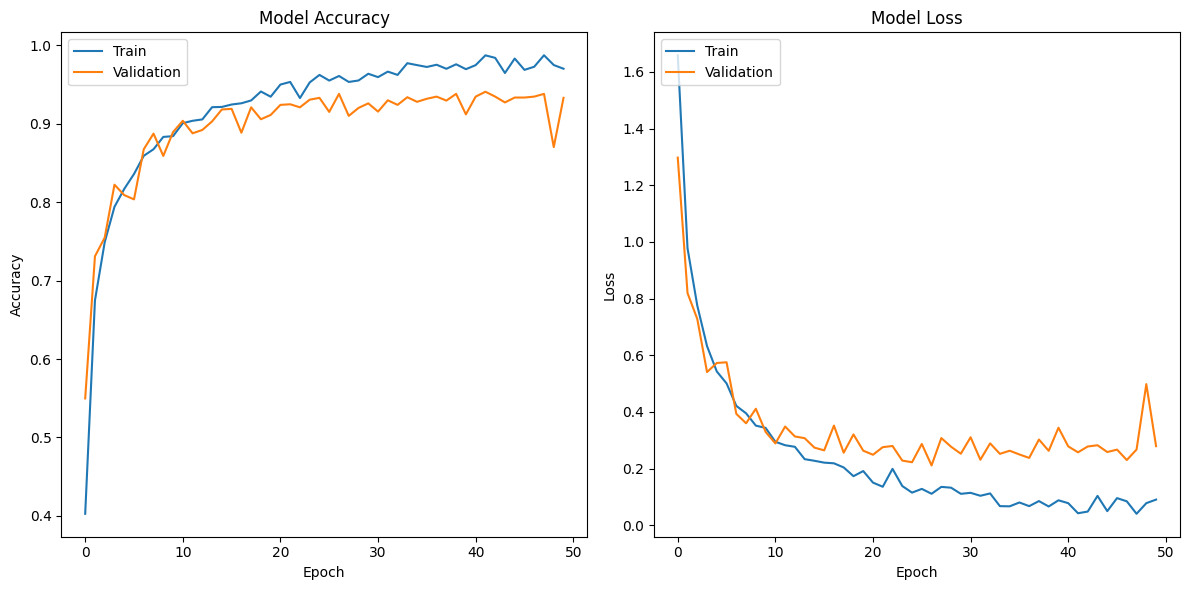

Validation Accuracy: 0.9329434633255005

Fold 2
Epoch 1/50
161/161 - 27s - loss: 1.6271 - accuracy: 0.4130 - val_loss: 1.2652 - val_accuracy: 0.5474 - 27s/epoch - 165ms/step
Epoch 2/50
161/161 - 21s - loss: 0.9776 - accuracy: 0.6632 - val_loss: 0.9051 - val_accuracy: 0.6959 - 21s/epoch - 128ms/step
Epoch 3/50
161/161 - 21s - loss: 0.7868 - accuracy: 0.7344 - val_loss: 0.6476 - val_accuracy: 0.7922 - 21s/epoch - 127ms/step
Epoch 4/50
161/161 - 21s - loss: 0.5852 - accuracy: 0.8077 - val_loss: 0.6199 - val_accuracy: 0.8031 - 21s/epoch - 129ms/step
Epoch 5/50
161/161 - 21s - loss: 0.5449 - accuracy: 0.8213 - val_loss: 0.5205 - val_accuracy: 0.8253 - 21s/epoch - 130ms/step
Epoch 6/50
161/161 - 21s - loss: 0.4331 - accuracy: 0.8607 - val_loss: 0.5611 - val_accuracy: 0.8172 - 21s/epoch - 128ms/step
Epoch 7/50
161/161 - 21s - loss: 0.4151 - accuracy: 0.8640 - val_loss: 0.4639 - val_accuracy: 0.8429 - 21s/epoch - 128ms/step
Epoch 8/50
161/161 - 21s - loss: 0.3895 - accuracy: 0.8676 - val_loss:

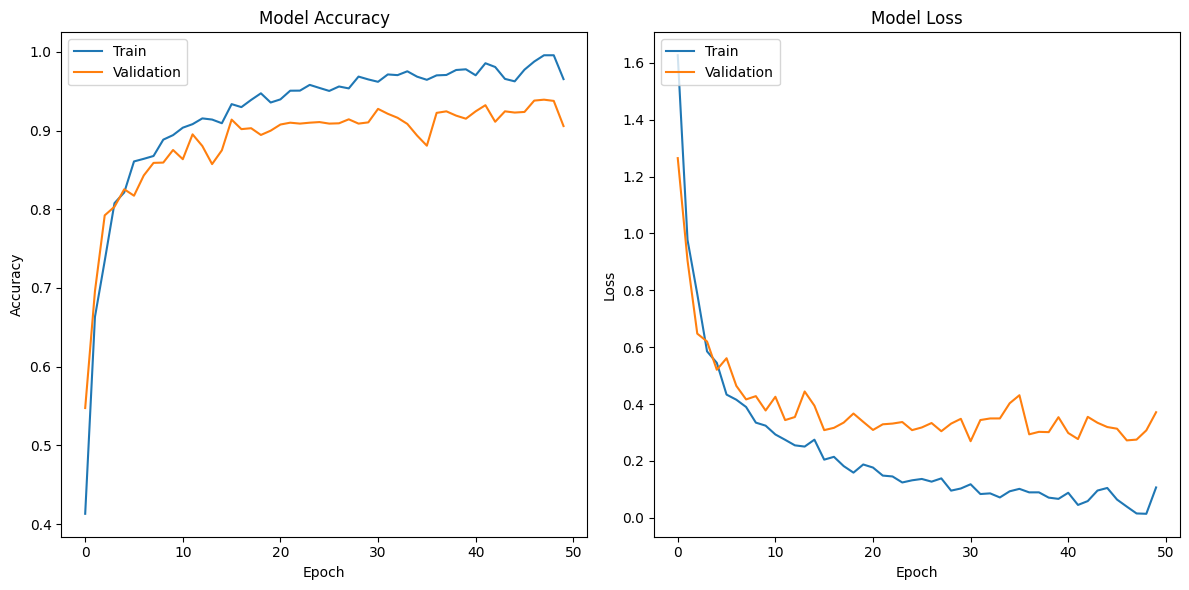

Validation Accuracy: 0.9056529998779297

Fold 3
Epoch 1/50
161/161 - 26s - loss: 1.6776 - accuracy: 0.3806 - val_loss: 1.2137 - val_accuracy: 0.5583 - 26s/epoch - 163ms/step
Epoch 2/50
161/161 - 19s - loss: 1.0011 - accuracy: 0.6565 - val_loss: 0.8253 - val_accuracy: 0.7119 - 19s/epoch - 118ms/step
Epoch 3/50
161/161 - 19s - loss: 0.8232 - accuracy: 0.7159 - val_loss: 0.7373 - val_accuracy: 0.7610 - 19s/epoch - 118ms/step
Epoch 4/50
161/161 - 19s - loss: 0.6590 - accuracy: 0.7822 - val_loss: 0.6078 - val_accuracy: 0.7965 - 19s/epoch - 118ms/step
Epoch 5/50
161/161 - 19s - loss: 0.5719 - accuracy: 0.8096 - val_loss: 0.5929 - val_accuracy: 0.7938 - 19s/epoch - 121ms/step
Epoch 6/50
161/161 - 19s - loss: 0.4980 - accuracy: 0.8326 - val_loss: 0.4966 - val_accuracy: 0.8363 - 19s/epoch - 118ms/step
Epoch 7/50
161/161 - 19s - loss: 0.4833 - accuracy: 0.8409 - val_loss: 0.6839 - val_accuracy: 0.7883 - 19s/epoch - 119ms/step
Epoch 8/50
161/161 - 19s - loss: 0.4164 - accuracy: 0.8611 - val_loss:

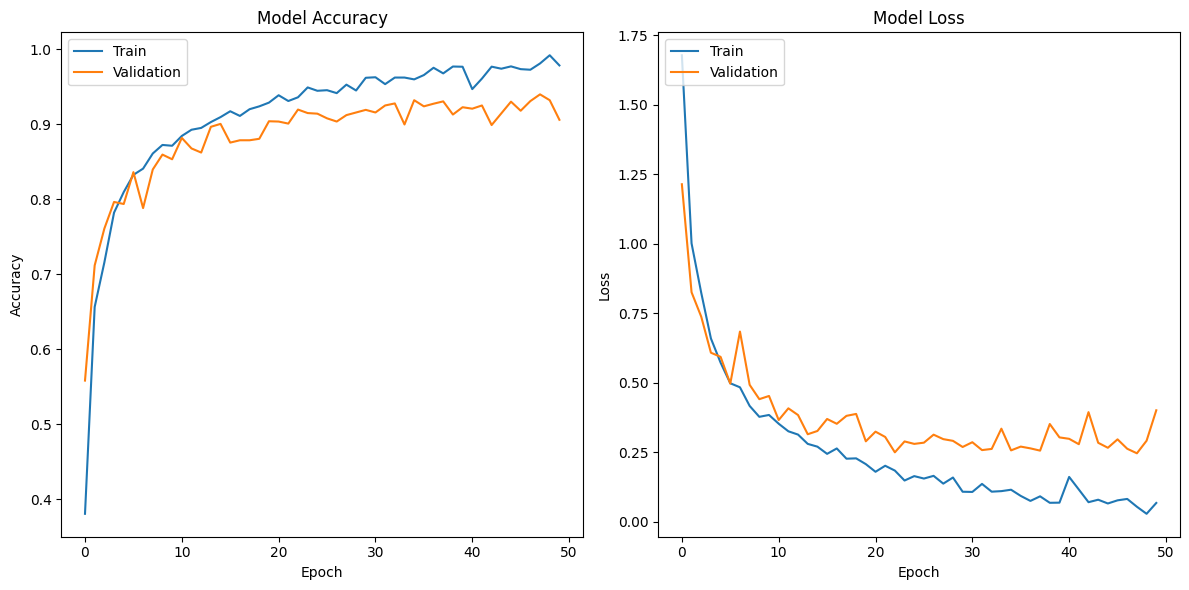

Validation Accuracy: 0.9060428738594055

Fold 4
Epoch 1/50
161/161 - 26s - loss: 1.7205 - accuracy: 0.3813 - val_loss: 1.2345 - val_accuracy: 0.5548 - 26s/epoch - 164ms/step
Epoch 2/50
161/161 - 19s - loss: 1.0643 - accuracy: 0.6297 - val_loss: 1.1335 - val_accuracy: 0.6004 - 19s/epoch - 120ms/step
Epoch 3/50
161/161 - 20s - loss: 0.8169 - accuracy: 0.7238 - val_loss: 1.0515 - val_accuracy: 0.6495 - 20s/epoch - 123ms/step
Epoch 4/50
161/161 - 19s - loss: 0.6636 - accuracy: 0.7792 - val_loss: 0.7001 - val_accuracy: 0.7680 - 19s/epoch - 121ms/step
Epoch 5/50
161/161 - 19s - loss: 0.5882 - accuracy: 0.8077 - val_loss: 0.6638 - val_accuracy: 0.7887 - 19s/epoch - 119ms/step
Epoch 6/50
161/161 - 20s - loss: 0.5133 - accuracy: 0.8294 - val_loss: 0.6543 - val_accuracy: 0.7926 - 20s/epoch - 122ms/step
Epoch 7/50
161/161 - 19s - loss: 0.4749 - accuracy: 0.8456 - val_loss: 0.5873 - val_accuracy: 0.8074 - 19s/epoch - 121ms/step
Epoch 8/50
161/161 - 20s - loss: 0.4136 - accuracy: 0.8641 - val_loss:

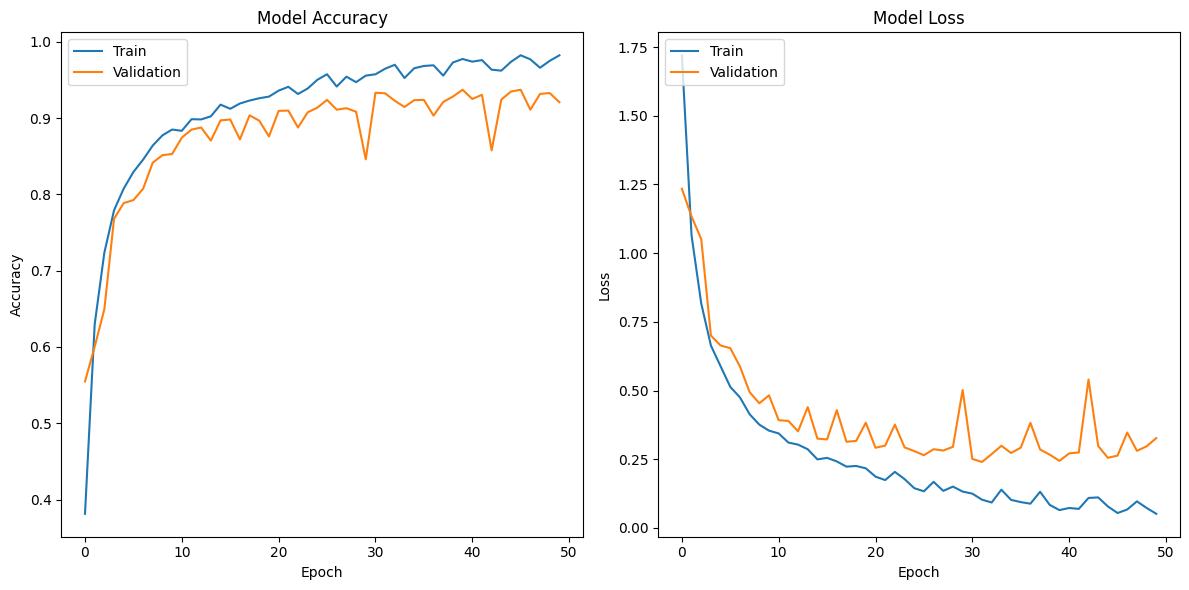

Validation Accuracy: 0.9208577275276184

Fold 5
Epoch 1/50
161/161 - 26s - loss: 1.6968 - accuracy: 0.3742 - val_loss: 1.2738 - val_accuracy: 0.5581 - 26s/epoch - 159ms/step
Epoch 2/50
161/161 - 19s - loss: 1.1585 - accuracy: 0.5904 - val_loss: 1.0588 - val_accuracy: 0.6299 - 19s/epoch - 119ms/step
Epoch 3/50
161/161 - 19s - loss: 0.8647 - accuracy: 0.7074 - val_loss: 0.6980 - val_accuracy: 0.7730 - 19s/epoch - 120ms/step
Epoch 4/50
161/161 - 19s - loss: 0.6961 - accuracy: 0.7721 - val_loss: 0.6324 - val_accuracy: 0.7832 - 19s/epoch - 120ms/step
Epoch 5/50
161/161 - 19s - loss: 0.5753 - accuracy: 0.8111 - val_loss: 0.5498 - val_accuracy: 0.8245 - 19s/epoch - 120ms/step
Epoch 6/50
161/161 - 19s - loss: 0.4960 - accuracy: 0.8377 - val_loss: 0.5880 - val_accuracy: 0.8175 - 19s/epoch - 121ms/step
Epoch 7/50
161/161 - 19s - loss: 0.4641 - accuracy: 0.8463 - val_loss: 0.4629 - val_accuracy: 0.8549 - 19s/epoch - 120ms/step
Epoch 8/50
161/161 - 19s - loss: 0.3936 - accuracy: 0.8696 - val_loss:

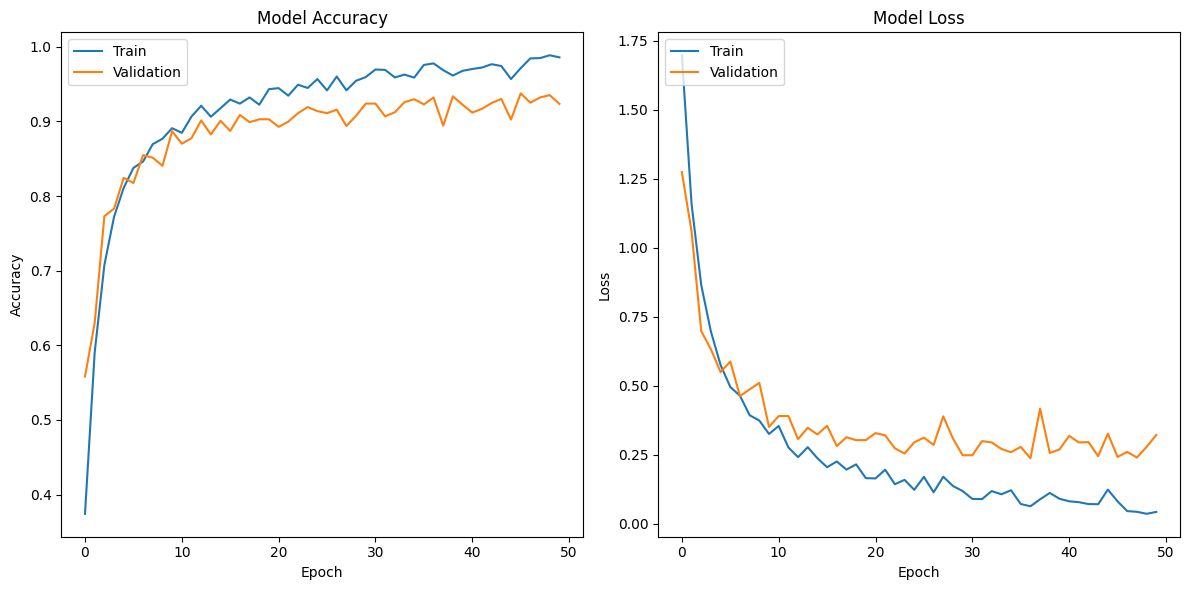

Validation Accuracy: 0.923556923866272



In [20]:
cnn_attention_gru = k_fold_cross_validation(X_train, y_train)

In [28]:
cnn_attention_gru[0].summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv1d_input (InputLayer)   [(None, 24, 1)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 22, 128)              512       ['conv1d_input[0][0]']        
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 11, 128)              0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 9, 256)               98560     ['max_pooling1d[0][0]']   

model number:  1
101/101 [==============================] - 4s 21ms/step
Accuracy: 0.9364
Precision: 0.9357
Sensitivity (Recall): 0.9364
F1 Score: 0.9357
Confusion Matrix:
[[316   0   0   0   2   0   0   0   0   2]
 [  0 296   2   3   2   4   8   2   0   0]
 [  0   3 308   0   2   1   0   0   0   0]
 [  1   2   0 310   6   1   4   2   0   2]
 [  1  18   2   4 241  16  18   0   0   2]
 [  0   1   7   1  14 298   4   0   0   1]
 [  0  13   6   5  25  11 260   1   0   3]
 [  0   0   0   0   0   0   2 314   0   0]
 [  0   0   0   0   0   0   0   0 327   0]
 [  0   0   0   0   0   0   0   0   0 332]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       320
           1       0.89      0.93      0.91       317
           2       0.95      0.98      0.96       314
           3       0.96      0.95      0.95       328
           4       0.83      0.80      0.81       302
           5       0.90      0.91      0.91      

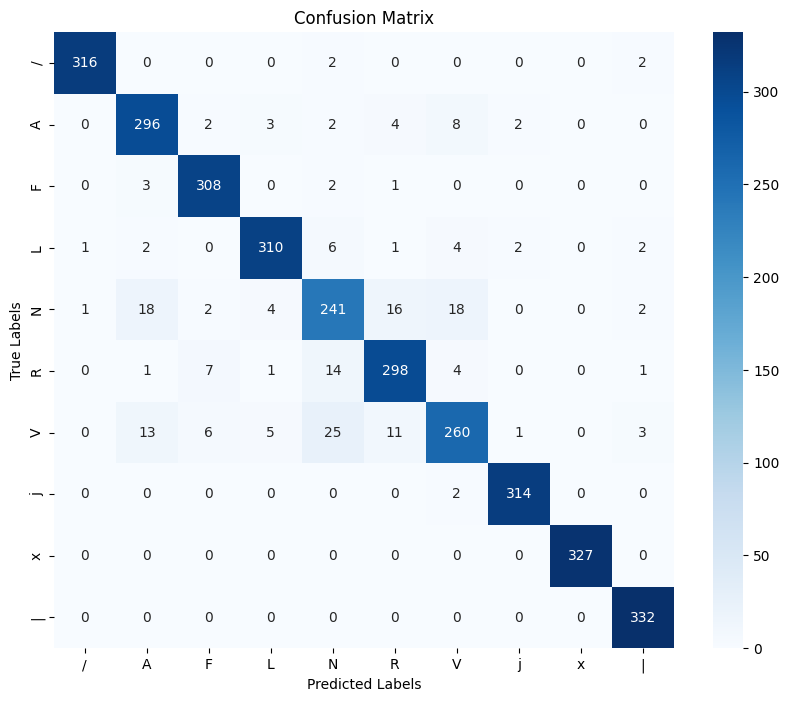

model number:  2
101/101 [==============================] - 3s 20ms/step
Accuracy: 0.9217
Precision: 0.9224
Sensitivity (Recall): 0.9217
F1 Score: 0.9215
Confusion Matrix:
[[312   1   0   2   5   0   0   0   0   0]
 [  2 281   1   0  10   2  15   6   0   0]
 [  0   4 291   0   7  11   1   0   0   0]
 [  2   2   0 302   8   4   9   0   0   1]
 [  5  11   2   2 224  24  31   0   1   2]
 [  0   0   0   0   6 312   6   1   0   1]
 [  0  14   8   0  21   6 268   0   7   0]
 [  0   1   0   0   0   0   0 315   0   0]
 [  0   0   0   0   0   0   0   0 327   0]
 [  0   2   0   0   0   4   3   0   0 323]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       320
           1       0.89      0.89      0.89       317
           2       0.96      0.93      0.94       314
           3       0.99      0.92      0.95       328
           4       0.80      0.74      0.77       302
           5       0.86      0.96      0.91      

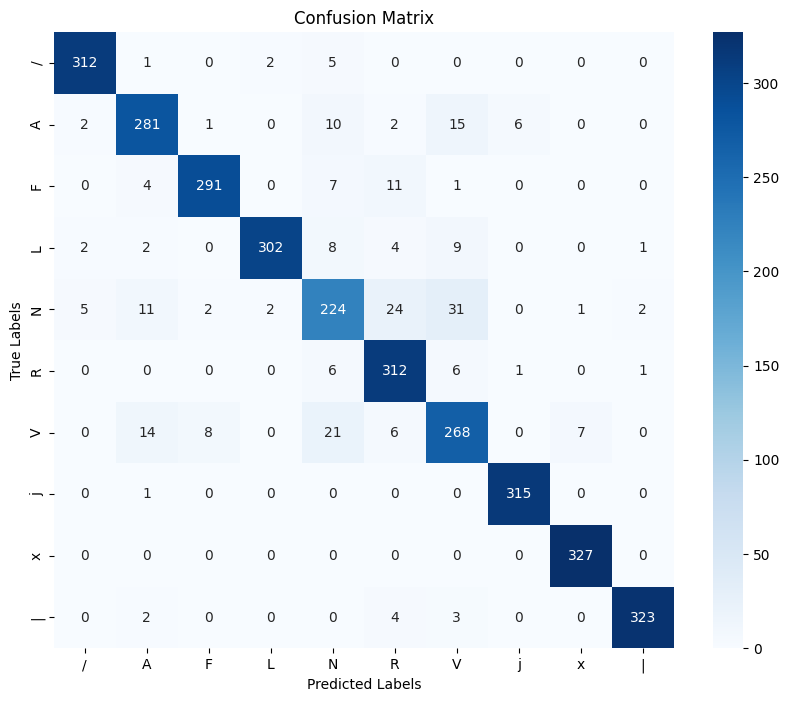

model number:  3
101/101 [==============================] - 3s 21ms/step
Accuracy: 0.9136
Precision: 0.9115
Sensitivity (Recall): 0.9136
F1 Score: 0.9110
Confusion Matrix:
[[317   0   0   1   0   0   0   1   1   0]
 [  0 284   2   2   2   5  10  11   1   0]
 [  0   4 290   0  12   2   5   0   0   1]
 [  6   3   0 312   1   1   1   4   0   0]
 [  3  24   3   9 202  24  23   3   6   5]
 [  0   0   0   0   4 312   3   1   3   3]
 [  1  14   5   3  27  15 242   0   7  10]
 [  0   1   0   0   0   0   0 315   0   0]
 [  0   0   0   0   0   0   0   0 327   0]
 [  0   1   0   0   2   0   0   1   0 328]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       320
           1       0.86      0.90      0.88       317
           2       0.97      0.92      0.94       314
           3       0.95      0.95      0.95       328
           4       0.81      0.67      0.73       302
           5       0.87      0.96      0.91      

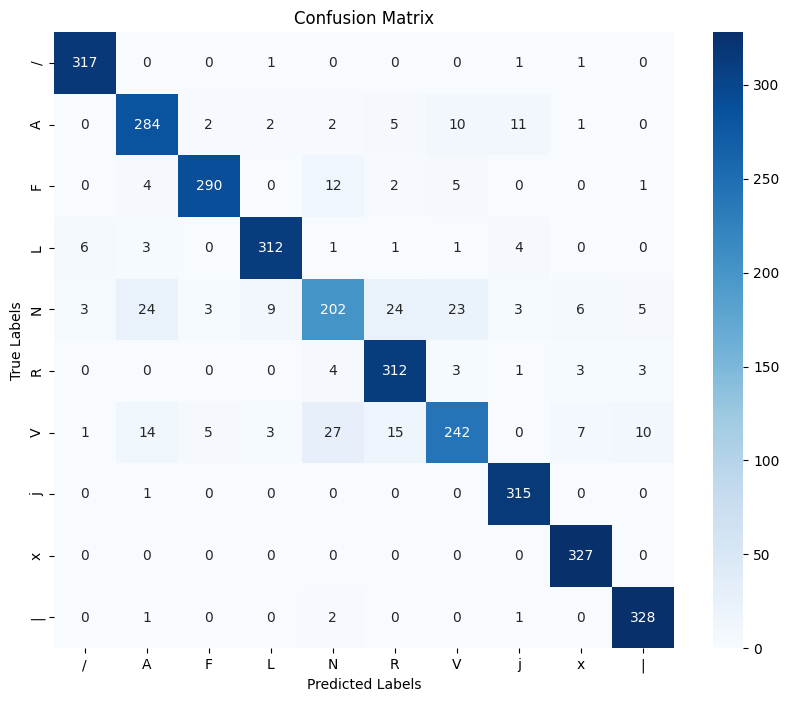

model number:  4
101/101 [==============================] - 3s 22ms/step
Accuracy: 0.9304
Precision: 0.9300
Sensitivity (Recall): 0.9304
F1 Score: 0.9296
Confusion Matrix:
[[320   0   0   0   0   0   0   0   0   0]
 [  5 279   3   2  13   1  10   4   0   0]
 [  0   0 313   0   0   0   1   0   0   0]
 [  8   0   0 306  11   0   1   0   0   2]
 [ 12   5   3   6 231   9  21   4   3   8]
 [  0   4   1   0  11 299   7   0   0   4]
 [  2   7   7   1  34   3 260   0   1   9]
 [  0   0   0   0   0   0   0 316   0   0]
 [  0   0   0   0   0   0   0   0 327   0]
 [  0   0   0   0   0   0   0   0   0 332]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       320
           1       0.95      0.88      0.91       317
           2       0.96      1.00      0.98       314
           3       0.97      0.93      0.95       328
           4       0.77      0.76      0.77       302
           5       0.96      0.92      0.94      

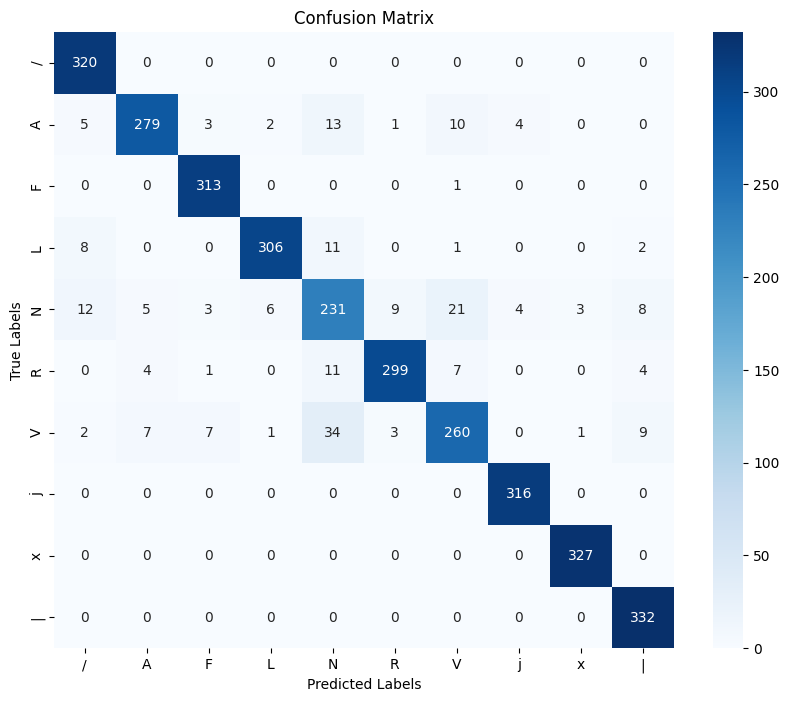

model number:  5
101/101 [==============================] - 3s 21ms/step
Accuracy: 0.9292
Precision: 0.9277
Sensitivity (Recall): 0.9292
F1 Score: 0.9276
Confusion Matrix:
[[317   0   0   3   0   0   0   0   0   0]
 [  0 279   1   4  13   8   8   1   1   2]
 [  0   0 308   0   2   3   1   0   0   0]
 [  2   0   0 318   3   0   1   0   0   4]
 [  2   4   4   6 224  25  27   1   3   6]
 [  1   0   2   0   2 308  10   0   1   2]
 [  1   8   6   5  26   6 250   0  13   9]
 [  0   0   0   0   0   0   0 316   0   0]
 [  0   0   0   0   0   0   0   0 327   0]
 [  0   0   0   0   0   0   0   0   0 332]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       320
           1       0.96      0.88      0.92       317
           2       0.96      0.98      0.97       314
           3       0.95      0.97      0.96       328
           4       0.83      0.74      0.78       302
           5       0.88      0.94      0.91      

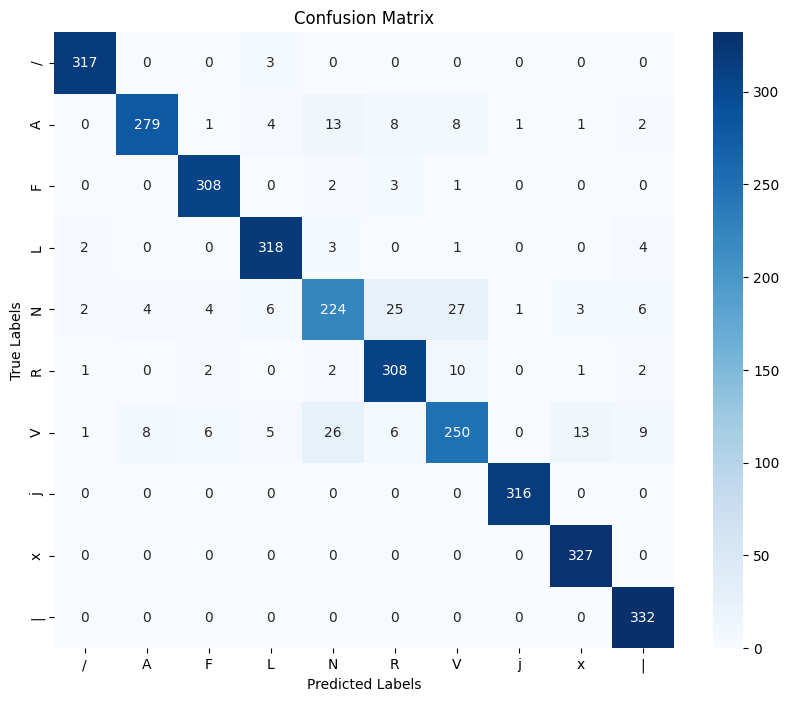

In [21]:
for i in range(5):
    print("model number: ", 1+i)
    y_pred = cnn_attention_gru[i].predict(X_test)
    y_pred_classes = y_pred.argmax(axis=-1)

    # Menghitung dan mencetak akurasi
    accuracy = accuracy_score(y_test, y_pred_classes)
    print(f'Accuracy: {accuracy:.4f}')

    # Menghitung dan mencetak precision
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Menghitung dan mencetak sensitivity (recall)
    sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
    print(f'Sensitivity (Recall): {sensitivity:.4f}')

    # Menghitung dan mencetak F1 Score
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print(f'F1 Score: {f1:.4f}')

    # Menghitung dan mencetak confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    print('Confusion Matrix:')
    print(conf_matrix)

    # Menghitung dan mencetak classification report
    class_report = classification_report(y_test, y_pred_classes)
    print('Classification Report:')
    print(class_report)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [43]:
# Menghitung dan mencetak precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Menghitung dan mencetak sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Sensitivity (Recall): {sensitivity:.4f}')

# Menghitung dan mencetak F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9427
Sensitivity (Recall): 0.9439
F1 Score: 0.9426


#2 CNN-LSTM

In [44]:
# Fungsi untuk melakukan K-fold cross-validation
def k_fold_cross_validation(X, y, k=5, epochs=50, batch_size=64):
    # Inisialisasi KFold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Daftar untuk menyimpan model pada setiap fold
    models = []
    
    # Loop melalui setiap fold
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        print(f'Fold {fold}')
        
        # Split data menjadi data latih dan data validasi
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Inisialisasi model
        model = create_cnn_lstm_model(input_shape=input_shape, num_classes=num_classes)
        
        # Latih model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=2)
        
        plot_training_history(history)
        
        # Evaluasi model pada data validasi
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        print(f'Validation Accuracy: {accuracy}')
        
        # Tambahkan model ke dalam daftar
        models.append(model)
        
        print()
    
    return models


Fold 1
Epoch 1/50
161/161 - 13s - loss: 1.1769 - accuracy: 0.6272 - val_loss: 2.2839 - val_accuracy: 0.1014 - 13s/epoch - 83ms/step
Epoch 2/50
161/161 - 6s - loss: 0.6682 - accuracy: 0.7942 - val_loss: 1.8742 - val_accuracy: 0.1439 - 6s/epoch - 34ms/step
Epoch 3/50
161/161 - 6s - loss: 0.5167 - accuracy: 0.8390 - val_loss: 0.7121 - val_accuracy: 0.8405 - 6s/epoch - 36ms/step
Epoch 4/50
161/161 - 5s - loss: 0.4203 - accuracy: 0.8686 - val_loss: 0.3759 - val_accuracy: 0.8795 - 5s/epoch - 31ms/step
Epoch 5/50
161/161 - 5s - loss: 0.3855 - accuracy: 0.8825 - val_loss: 0.3172 - val_accuracy: 0.9084 - 5s/epoch - 33ms/step
Epoch 6/50
161/161 - 5s - loss: 0.3382 - accuracy: 0.8947 - val_loss: 0.2594 - val_accuracy: 0.9185 - 5s/epoch - 32ms/step
Epoch 7/50
161/161 - 5s - loss: 0.2904 - accuracy: 0.9074 - val_loss: 0.2543 - val_accuracy: 0.9216 - 5s/epoch - 33ms/step
Epoch 8/50
161/161 - 6s - loss: 0.2679 - accuracy: 0.9154 - val_loss: 0.2417 - val_accuracy: 0.9306 - 6s/epoch - 35ms/step
Epoch 9

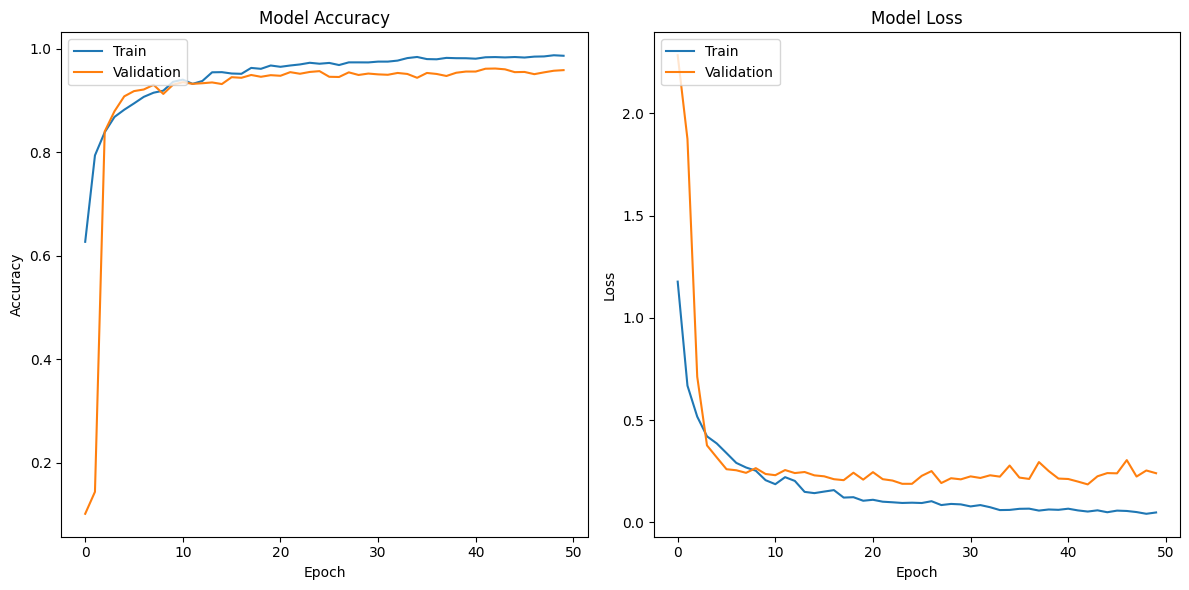

Validation Accuracy: 0.9590643048286438

Fold 2
Epoch 1/50
161/161 - 13s - loss: 1.1494 - accuracy: 0.6323 - val_loss: 2.2272 - val_accuracy: 0.1033 - 13s/epoch - 78ms/step
Epoch 2/50
161/161 - 5s - loss: 0.6396 - accuracy: 0.8025 - val_loss: 1.5372 - val_accuracy: 0.5353 - 5s/epoch - 31ms/step
Epoch 3/50
161/161 - 5s - loss: 0.4918 - accuracy: 0.8484 - val_loss: 0.6380 - val_accuracy: 0.8511 - 5s/epoch - 33ms/step
Epoch 4/50
161/161 - 5s - loss: 0.4399 - accuracy: 0.8647 - val_loss: 0.3361 - val_accuracy: 0.8994 - 5s/epoch - 32ms/step
Epoch 5/50
161/161 - 5s - loss: 0.3551 - accuracy: 0.8915 - val_loss: 0.4006 - val_accuracy: 0.8635 - 5s/epoch - 31ms/step
Epoch 6/50
161/161 - 5s - loss: 0.3000 - accuracy: 0.9081 - val_loss: 0.3508 - val_accuracy: 0.8971 - 5s/epoch - 31ms/step
Epoch 7/50
161/161 - 5s - loss: 0.2807 - accuracy: 0.9131 - val_loss: 0.2651 - val_accuracy: 0.9173 - 5s/epoch - 31ms/step
Epoch 8/50
161/161 - 5s - loss: 0.2564 - accuracy: 0.9229 - val_loss: 0.2675 - val_accura

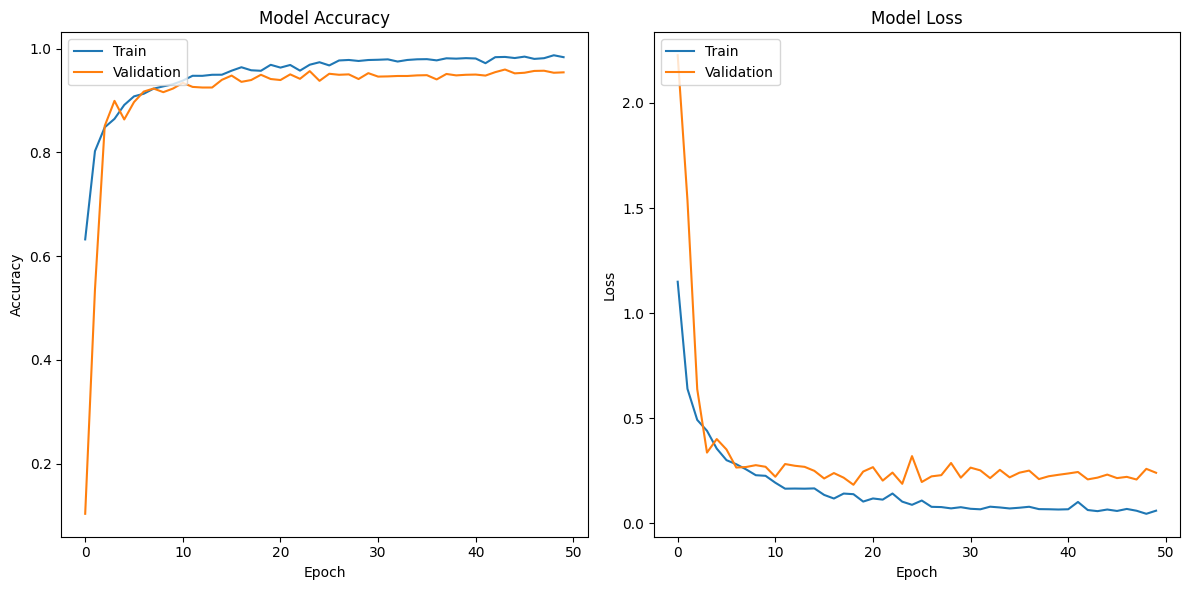

Validation Accuracy: 0.9543859362602234

Fold 3
Epoch 1/50
161/161 - 17s - loss: 1.1333 - accuracy: 0.6369 - val_loss: 2.2344 - val_accuracy: 0.1029 - 17s/epoch - 106ms/step
Epoch 2/50
161/161 - 6s - loss: 0.6230 - accuracy: 0.8116 - val_loss: 1.6712 - val_accuracy: 0.3010 - 6s/epoch - 34ms/step
Epoch 3/50
161/161 - 5s - loss: 0.5163 - accuracy: 0.8444 - val_loss: 0.8831 - val_accuracy: 0.7680 - 5s/epoch - 33ms/step
Epoch 4/50
161/161 - 5s - loss: 0.4284 - accuracy: 0.8690 - val_loss: 0.3344 - val_accuracy: 0.9006 - 5s/epoch - 32ms/step
Epoch 5/50
161/161 - 5s - loss: 0.3678 - accuracy: 0.8885 - val_loss: 0.3253 - val_accuracy: 0.9033 - 5s/epoch - 32ms/step
Epoch 6/50
161/161 - 6s - loss: 0.3340 - accuracy: 0.8979 - val_loss: 0.2865 - val_accuracy: 0.9123 - 6s/epoch - 38ms/step
Epoch 7/50
161/161 - 6s - loss: 0.3152 - accuracy: 0.9015 - val_loss: 0.2358 - val_accuracy: 0.9263 - 6s/epoch - 39ms/step
Epoch 8/50
161/161 - 5s - loss: 0.2629 - accuracy: 0.9192 - val_loss: 0.2484 - val_accur

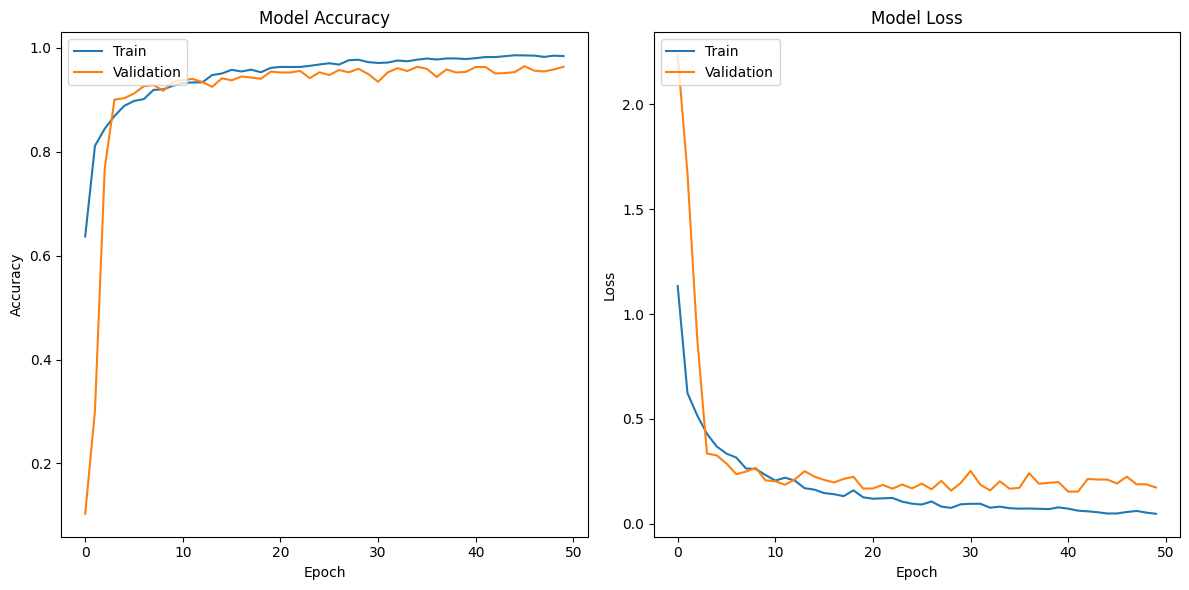

Validation Accuracy: 0.9637426733970642

Fold 4
Epoch 1/50
161/161 - 16s - loss: 1.1653 - accuracy: 0.6246 - val_loss: 2.3139 - val_accuracy: 0.1014 - 16s/epoch - 102ms/step
Epoch 2/50
161/161 - 6s - loss: 0.6422 - accuracy: 0.7962 - val_loss: 1.5901 - val_accuracy: 0.4090 - 6s/epoch - 36ms/step
Epoch 3/50
161/161 - 6s - loss: 0.5186 - accuracy: 0.8390 - val_loss: 0.7077 - val_accuracy: 0.8316 - 6s/epoch - 35ms/step
Epoch 4/50
161/161 - 6s - loss: 0.4432 - accuracy: 0.8611 - val_loss: 0.3648 - val_accuracy: 0.8850 - 6s/epoch - 35ms/step
Epoch 5/50
161/161 - 6s - loss: 0.3747 - accuracy: 0.8834 - val_loss: 0.3580 - val_accuracy: 0.8823 - 6s/epoch - 36ms/step
Epoch 6/50
161/161 - 6s - loss: 0.3319 - accuracy: 0.8967 - val_loss: 0.2711 - val_accuracy: 0.9138 - 6s/epoch - 35ms/step
Epoch 7/50
161/161 - 6s - loss: 0.3120 - accuracy: 0.9034 - val_loss: 0.2325 - val_accuracy: 0.9263 - 6s/epoch - 36ms/step
Epoch 8/50
161/161 - 6s - loss: 0.2685 - accuracy: 0.9164 - val_loss: 0.2619 - val_accur

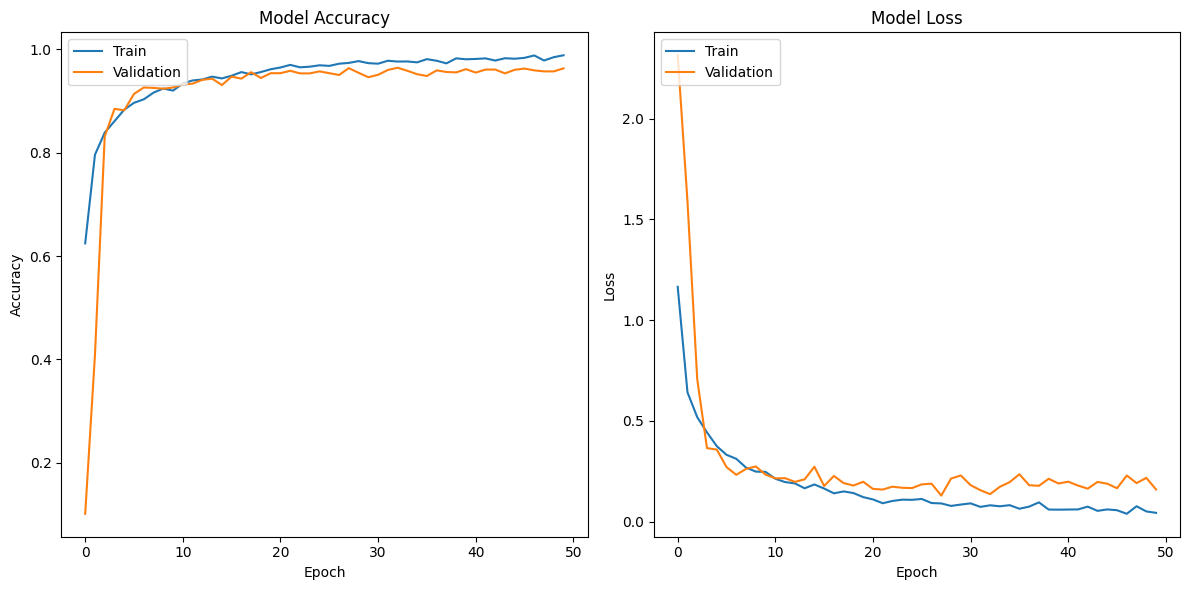

Validation Accuracy: 0.9633527994155884

Fold 5
Epoch 1/50
161/161 - 13s - loss: 1.1804 - accuracy: 0.6226 - val_loss: 2.2466 - val_accuracy: 0.1014 - 13s/epoch - 84ms/step
Epoch 2/50
161/161 - 6s - loss: 0.6534 - accuracy: 0.7986 - val_loss: 1.5962 - val_accuracy: 0.4762 - 6s/epoch - 35ms/step
Epoch 3/50
161/161 - 6s - loss: 0.5353 - accuracy: 0.8351 - val_loss: 0.6330 - val_accuracy: 0.8662 - 6s/epoch - 38ms/step
Epoch 4/50
161/161 - 5s - loss: 0.4135 - accuracy: 0.8720 - val_loss: 0.3796 - val_accuracy: 0.8873 - 5s/epoch - 33ms/step
Epoch 5/50
161/161 - 5s - loss: 0.3790 - accuracy: 0.8805 - val_loss: 0.3678 - val_accuracy: 0.8803 - 5s/epoch - 32ms/step
Epoch 6/50
161/161 - 5s - loss: 0.3371 - accuracy: 0.8974 - val_loss: 0.3293 - val_accuracy: 0.9005 - 5s/epoch - 31ms/step
Epoch 7/50
161/161 - 5s - loss: 0.3224 - accuracy: 0.9006 - val_loss: 0.3076 - val_accuracy: 0.9119 - 5s/epoch - 33ms/step
Epoch 8/50
161/161 - 5s - loss: 0.2559 - accuracy: 0.9197 - val_loss: 0.2863 - val_accura

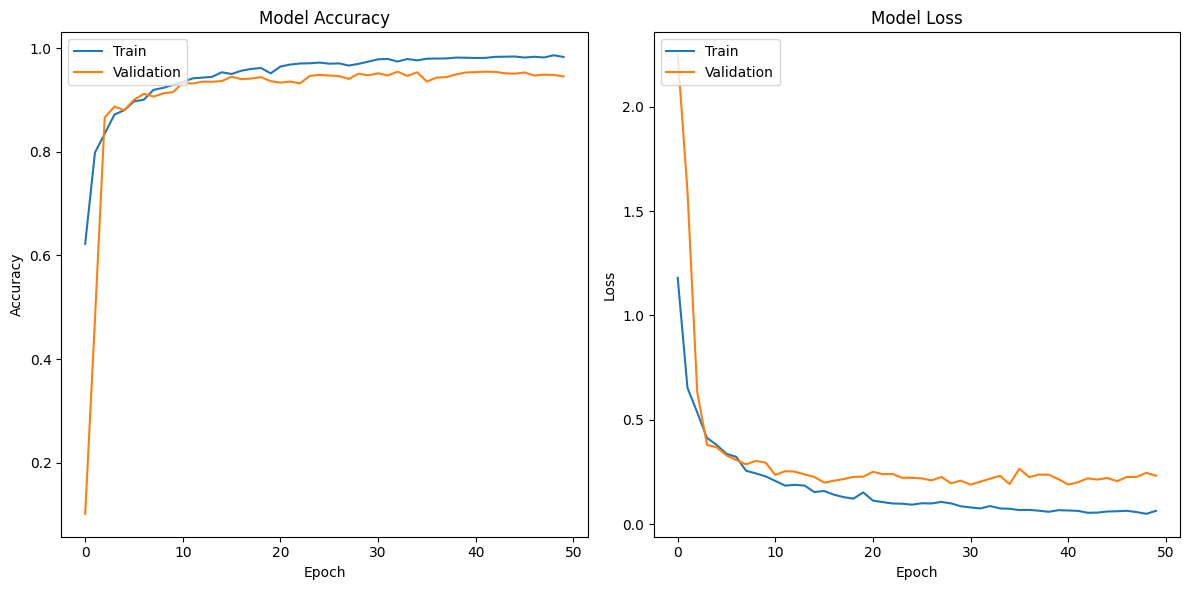

Validation Accuracy: 0.9453977942466736



In [45]:
cnn_lstm = k_fold_cross_validation(X_train, y_train)

101/101 [==============================] - 1s 6ms/step
Accuracy: 0.9657
Confusion Matrix:
[[317   0   0   2   0   1   0   0   0   0]
 [  0 315   0   0   0   1   0   1   0   0]
 [  0   1 313   0   0   0   0   0   0   0]
 [  2   0   0 322   3   1   0   0   0   0]
 [  0  12   2   1 260  12  11   2   0   2]
 [  0   2   2   0   5 316   1   0   0   0]
 [  0   9   4   2  21   4 278   1   2   3]
 [  0   0   0   0   0   0   0 316   0   0]
 [  0   0   0   0   0   0   0   0 327   0]
 [  0   0   0   0   0   0   0   0   0 332]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       320
           1       0.93      0.99      0.96       317
           2       0.98      1.00      0.99       314
           3       0.98      0.98      0.98       328
           4       0.90      0.86      0.88       302
           5       0.94      0.97      0.96       326
           6       0.96      0.86      0.91       324
           7       0.99

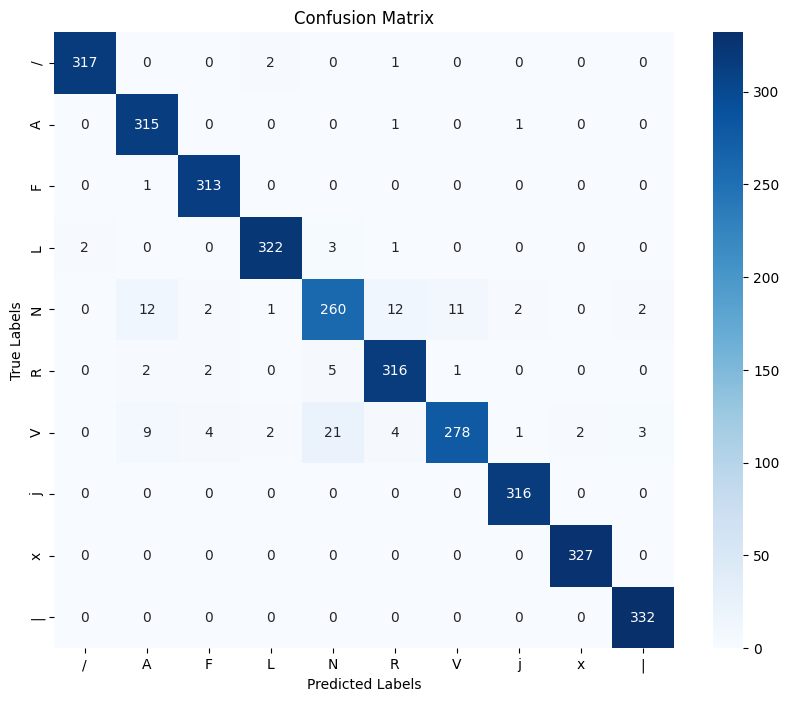

In [61]:
y_pred = cnn_lstm[2].predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Menghitung dan mencetak confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Menghitung dan mencetak classification report
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [62]:
# Menghitung dan mencetak precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Menghitung dan mencetak sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Sensitivity (Recall): {sensitivity:.4f}')

# Menghitung dan mencetak F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9656
Sensitivity (Recall): 0.9657
F1 Score: 0.9652


#3 CNN-GRU

In [48]:
# Fungsi untuk melakukan K-fold cross-validation
def k_fold_cross_validation(X, y, k=5, epochs=50, batch_size=64):
    # Inisialisasi KFold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Daftar untuk menyimpan model pada setiap fold
    models = []
    
    # Loop melalui setiap fold
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        print(f'Fold {fold}')
        
        # Split data menjadi data latih dan data validasi
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Inisialisasi model
        model = create_cnn_gru_model(input_shape=input_shape, num_classes=num_classes)
        
        # Latih model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=2)
        
        plot_training_history(history)
        
        # Evaluasi model pada data validasi
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        print(f'Validation Accuracy: {accuracy}')
        
        # Tambahkan model ke dalam daftar
        models.append(model)
        
        print()
    
    return models


Fold 1
Epoch 1/50
161/161 - 15s - loss: 1.4294 - accuracy: 0.5419 - val_loss: 2.1437 - val_accuracy: 0.1236 - 15s/epoch - 92ms/step
Epoch 2/50
161/161 - 5s - loss: 0.7951 - accuracy: 0.7531 - val_loss: 1.0137 - val_accuracy: 0.7583 - 5s/epoch - 30ms/step
Epoch 3/50
161/161 - 5s - loss: 0.5992 - accuracy: 0.8121 - val_loss: 0.4663 - val_accuracy: 0.8487 - 5s/epoch - 33ms/step
Epoch 4/50
161/161 - 5s - loss: 0.4946 - accuracy: 0.8464 - val_loss: 0.3285 - val_accuracy: 0.9010 - 5s/epoch - 34ms/step
Epoch 5/50
161/161 - 5s - loss: 0.4279 - accuracy: 0.8668 - val_loss: 0.3378 - val_accuracy: 0.9053 - 5s/epoch - 30ms/step
Epoch 6/50
161/161 - 5s - loss: 0.3703 - accuracy: 0.8830 - val_loss: 0.3243 - val_accuracy: 0.9080 - 5s/epoch - 30ms/step
Epoch 7/50
161/161 - 5s - loss: 0.3422 - accuracy: 0.8947 - val_loss: 0.3320 - val_accuracy: 0.9115 - 5s/epoch - 31ms/step
Epoch 8/50
161/161 - 5s - loss: 0.2860 - accuracy: 0.9132 - val_loss: 0.2699 - val_accuracy: 0.9290 - 5s/epoch - 30ms/step
Epoch 9

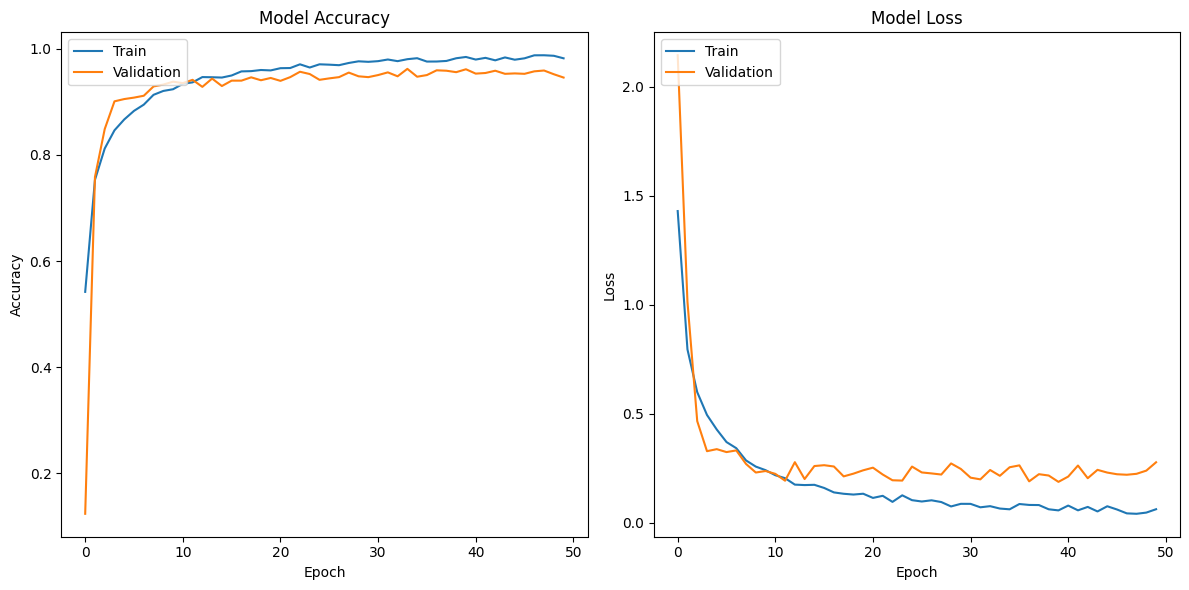

Validation Accuracy: 0.9458089470863342

Fold 2
Epoch 1/50
161/161 - 13s - loss: 1.4045 - accuracy: 0.5546 - val_loss: 2.1757 - val_accuracy: 0.1103 - 13s/epoch - 79ms/step
Epoch 2/50
161/161 - 4s - loss: 0.8137 - accuracy: 0.7552 - val_loss: 1.0771 - val_accuracy: 0.7474 - 4s/epoch - 28ms/step
Epoch 3/50
161/161 - 5s - loss: 0.6264 - accuracy: 0.8087 - val_loss: 0.4669 - val_accuracy: 0.8624 - 5s/epoch - 28ms/step
Epoch 4/50
161/161 - 5s - loss: 0.4963 - accuracy: 0.8508 - val_loss: 0.4298 - val_accuracy: 0.8624 - 5s/epoch - 31ms/step
Epoch 5/50
161/161 - 5s - loss: 0.4465 - accuracy: 0.8678 - val_loss: 0.3521 - val_accuracy: 0.8924 - 5s/epoch - 34ms/step
Epoch 6/50
161/161 - 5s - loss: 0.3839 - accuracy: 0.8831 - val_loss: 0.3108 - val_accuracy: 0.9080 - 5s/epoch - 31ms/step
Epoch 7/50
161/161 - 5s - loss: 0.3490 - accuracy: 0.8911 - val_loss: 0.3199 - val_accuracy: 0.9025 - 5s/epoch - 29ms/step
Epoch 8/50
161/161 - 5s - loss: 0.3079 - accuracy: 0.9067 - val_loss: 0.3060 - val_accura

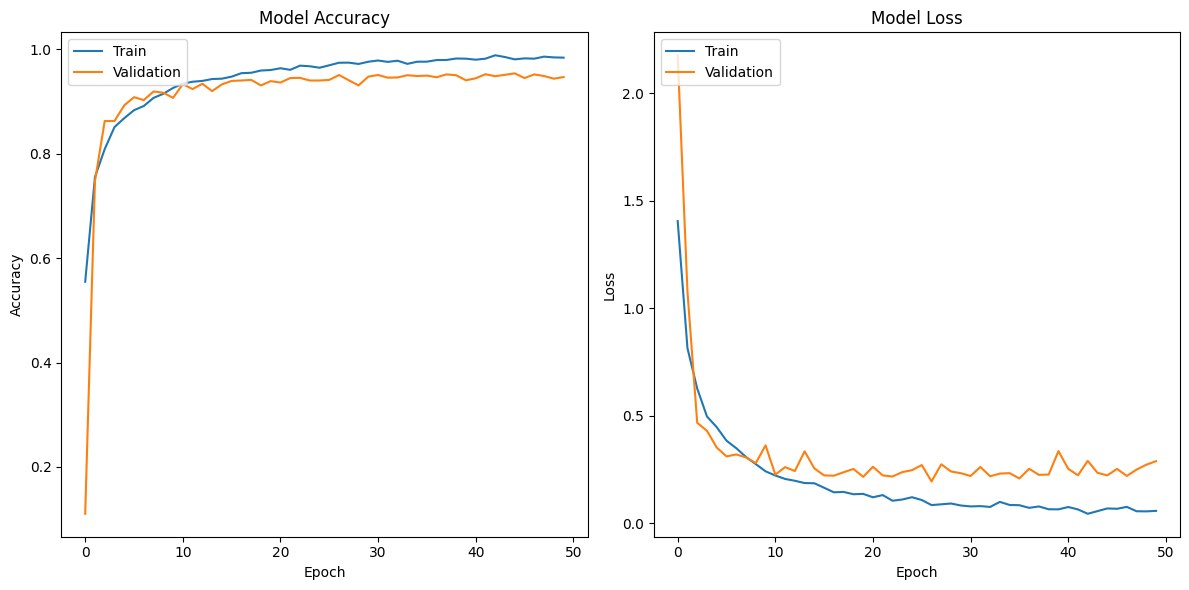

Validation Accuracy: 0.9465886950492859

Fold 3
Epoch 1/50
161/161 - 12s - loss: 1.4026 - accuracy: 0.5496 - val_loss: 2.1459 - val_accuracy: 0.1462 - 12s/epoch - 75ms/step
Epoch 2/50
161/161 - 5s - loss: 0.7900 - accuracy: 0.7541 - val_loss: 1.1399 - val_accuracy: 0.7041 - 5s/epoch - 28ms/step
Epoch 3/50
161/161 - 5s - loss: 0.6112 - accuracy: 0.8130 - val_loss: 0.5937 - val_accuracy: 0.8133 - 5s/epoch - 28ms/step
Epoch 4/50
161/161 - 5s - loss: 0.4884 - accuracy: 0.8534 - val_loss: 0.4262 - val_accuracy: 0.8643 - 5s/epoch - 29ms/step
Epoch 5/50
161/161 - 5s - loss: 0.4308 - accuracy: 0.8699 - val_loss: 0.3528 - val_accuracy: 0.8912 - 5s/epoch - 28ms/step
Epoch 6/50
161/161 - 5s - loss: 0.3751 - accuracy: 0.8851 - val_loss: 0.3721 - val_accuracy: 0.8889 - 5s/epoch - 32ms/step
Epoch 7/50
161/161 - 5s - loss: 0.3439 - accuracy: 0.8922 - val_loss: 0.2959 - val_accuracy: 0.9084 - 5s/epoch - 29ms/step
Epoch 8/50
161/161 - 5s - loss: 0.3230 - accuracy: 0.9001 - val_loss: 0.2942 - val_accura

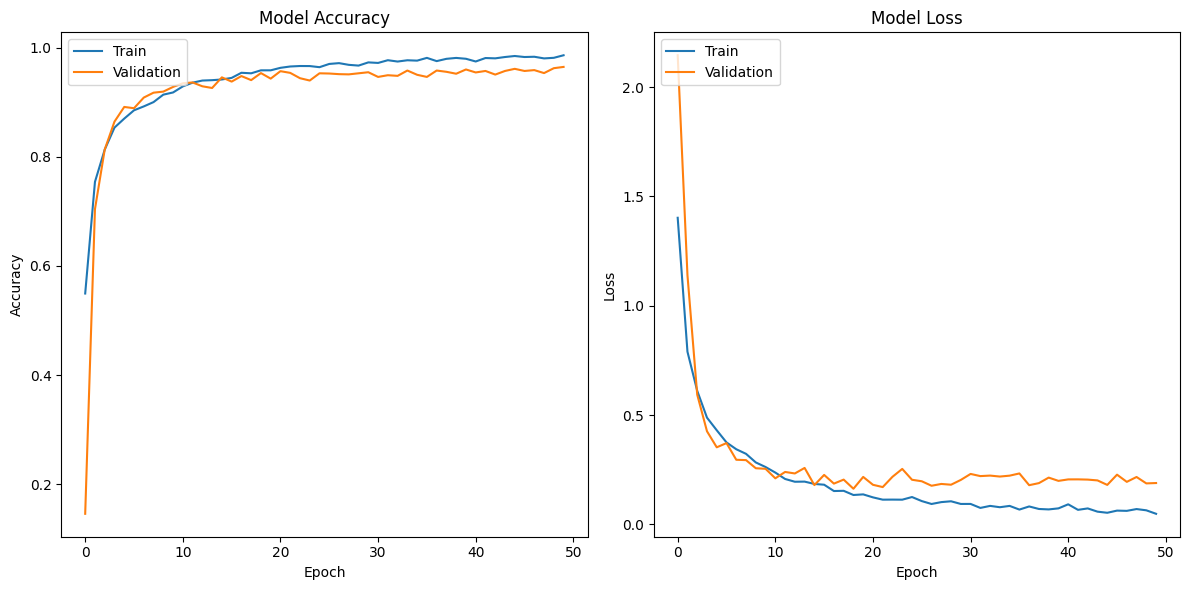

Validation Accuracy: 0.9645224213600159

Fold 4
Epoch 1/50
161/161 - 13s - loss: 1.4288 - accuracy: 0.5322 - val_loss: 2.1519 - val_accuracy: 0.1205 - 13s/epoch - 81ms/step
Epoch 2/50
161/161 - 5s - loss: 0.8116 - accuracy: 0.7500 - val_loss: 1.1227 - val_accuracy: 0.6409 - 5s/epoch - 31ms/step
Epoch 3/50
161/161 - 5s - loss: 0.6206 - accuracy: 0.8085 - val_loss: 0.4618 - val_accuracy: 0.8499 - 5s/epoch - 33ms/step
Epoch 4/50
161/161 - 5s - loss: 0.5074 - accuracy: 0.8429 - val_loss: 0.4152 - val_accuracy: 0.8706 - 5s/epoch - 31ms/step
Epoch 5/50
161/161 - 5s - loss: 0.4572 - accuracy: 0.8612 - val_loss: 0.3473 - val_accuracy: 0.8920 - 5s/epoch - 32ms/step
Epoch 6/50
161/161 - 5s - loss: 0.3996 - accuracy: 0.8773 - val_loss: 0.2965 - val_accuracy: 0.9107 - 5s/epoch - 29ms/step
Epoch 7/50
161/161 - 5s - loss: 0.3460 - accuracy: 0.8965 - val_loss: 0.3135 - val_accuracy: 0.9084 - 5s/epoch - 29ms/step
Epoch 8/50
161/161 - 5s - loss: 0.3101 - accuracy: 0.9022 - val_loss: 0.2954 - val_accura

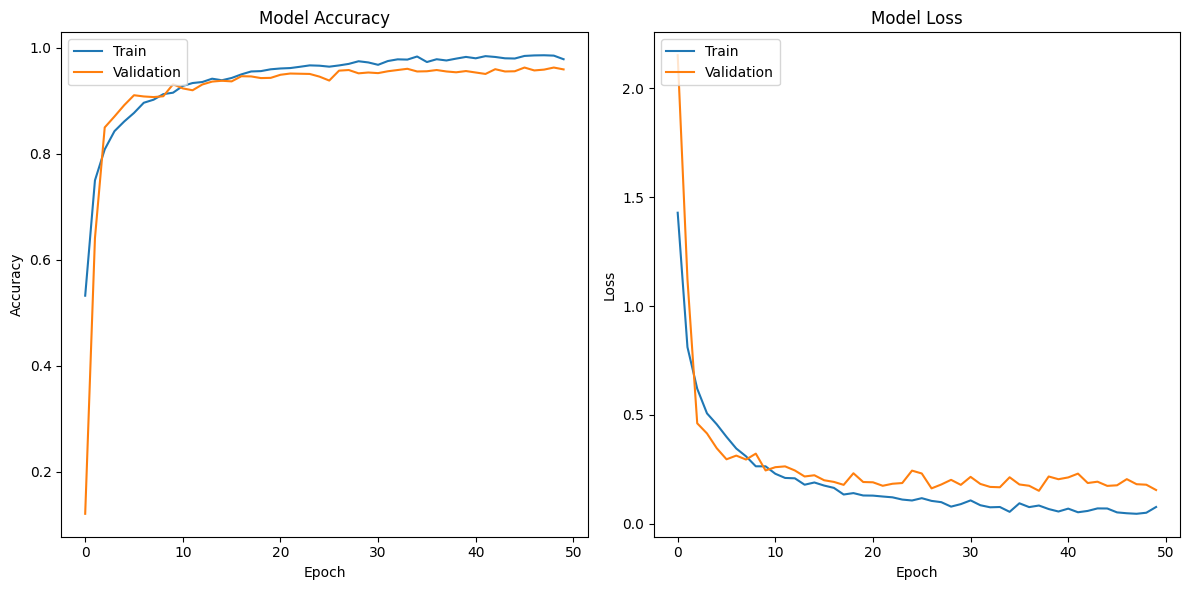

Validation Accuracy: 0.9594541788101196

Fold 5
Epoch 1/50
161/161 - 14s - loss: 1.4359 - accuracy: 0.5365 - val_loss: 2.1611 - val_accuracy: 0.1295 - 14s/epoch - 85ms/step
Epoch 2/50
161/161 - 5s - loss: 0.7973 - accuracy: 0.7600 - val_loss: 1.1862 - val_accuracy: 0.6513 - 5s/epoch - 29ms/step
Epoch 3/50
161/161 - 5s - loss: 0.6035 - accuracy: 0.8154 - val_loss: 0.5013 - val_accuracy: 0.8280 - 5s/epoch - 29ms/step
Epoch 4/50
161/161 - 5s - loss: 0.5030 - accuracy: 0.8468 - val_loss: 0.5189 - val_accuracy: 0.8502 - 5s/epoch - 30ms/step
Epoch 5/50
161/161 - 5s - loss: 0.4302 - accuracy: 0.8719 - val_loss: 0.3946 - val_accuracy: 0.8787 - 5s/epoch - 29ms/step
Epoch 6/50
161/161 - 5s - loss: 0.3829 - accuracy: 0.8838 - val_loss: 0.3436 - val_accuracy: 0.8935 - 5s/epoch - 29ms/step
Epoch 7/50
161/161 - 5s - loss: 0.3424 - accuracy: 0.8958 - val_loss: 0.3448 - val_accuracy: 0.8943 - 5s/epoch - 29ms/step
Epoch 8/50
161/161 - 5s - loss: 0.3018 - accuracy: 0.9100 - val_loss: 0.3020 - val_accura

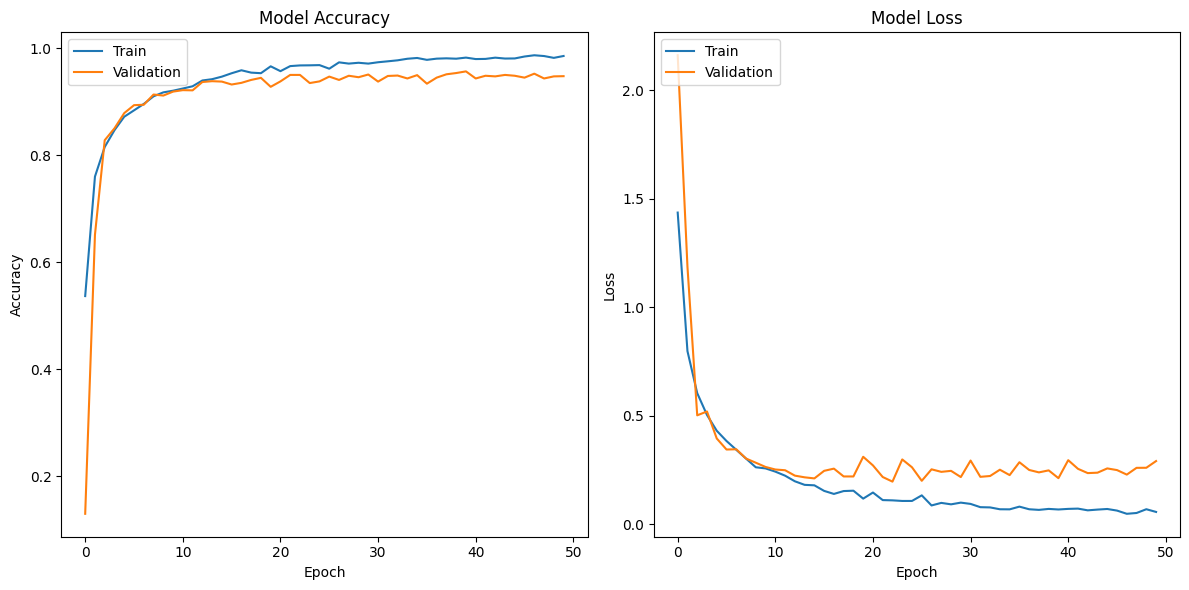

Validation Accuracy: 0.9477379322052002



In [49]:
cnn_gru = k_fold_cross_validation(X_train, y_train)

101/101 [==============================] - 1s 5ms/step
Accuracy: 0.9660
Confusion Matrix:
[[320   0   0   0   0   0   0   0   0   0]
 [  2 305   1   1   6   0   2   0   0   0]
 [  0   0 314   0   0   0   0   0   0   0]
 [  0   0   0 325   1   1   1   0   0   0]
 [  3   9   1   1 265   2  17   0   0   4]
 [  0   2   1   0  10 312   1   0   0   0]
 [  1   5   4   2  24   1 281   1   2   3]
 [  0   0   0   0   0   0   0 316   0   0]
 [  0   0   0   0   0   0   0   0 327   0]
 [  0   0   0   0   0   0   0   0   0 332]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       320
           1       0.95      0.96      0.96       317
           2       0.98      1.00      0.99       314
           3       0.99      0.99      0.99       328
           4       0.87      0.88      0.87       302
           5       0.99      0.96      0.97       326
           6       0.93      0.87      0.90       324
           7       1.00

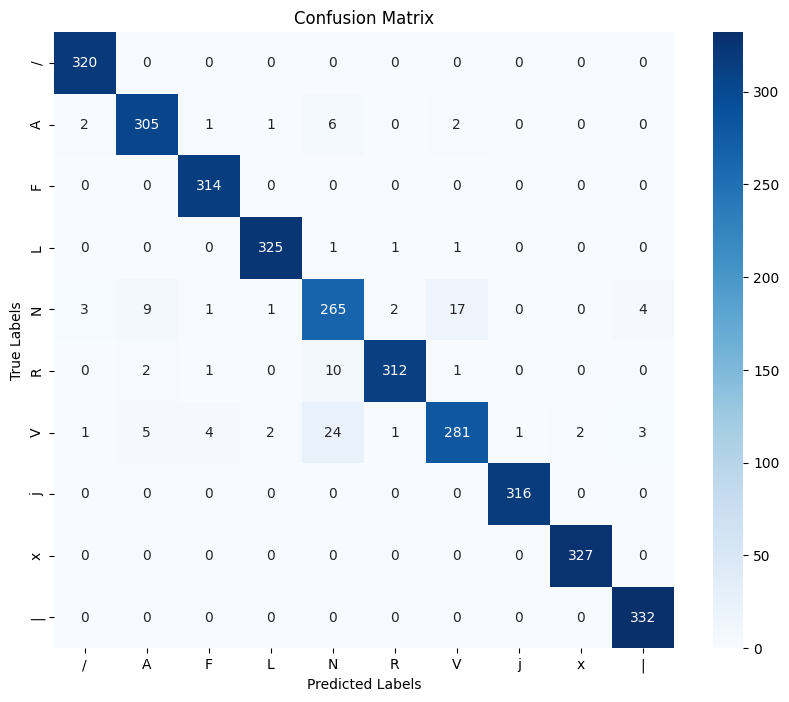

In [69]:
y_pred = cnn_gru[2].predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Menghitung dan mencetak confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Menghitung dan mencetak classification report
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [70]:
# Menghitung dan mencetak precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Menghitung dan mencetak sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Sensitivity (Recall): {sensitivity:.4f}')

# Menghitung dan mencetak F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9658
Sensitivity (Recall): 0.9660
F1 Score: 0.9657


In [22]:
with open("C:\\Users\\Administrator\\Documents\\my TA model\\cnn_attention_gru_list_non_tuning.pkl", "wb") as f:
    pickle.dump(cnn_attention_gru, f)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpweqxponp\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpweqxponp\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp5uw4nmbd\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp5uw4nmbd\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpb7vs2_bl\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpb7vs2_bl\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpisaa9lt_\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpisaa9lt_\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpqxcqf7fj\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpqxcqf7fj\assets


In [72]:
with open("C:\\Users\\Administrator\\Documents\\my TA model\\cnn_lstm_list_non_tuning.pkl", "wb") as f:
    pickle.dump(cnn_lstm, f)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpq0bgx0q3\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpq0bgx0q3\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmppsdxumgv\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmppsdxumgv\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp9g0llmgl\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp9g0llmgl\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpm9rvo5ag\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpm9rvo5ag\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp8as6lsrg\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp8as6lsrg\assets


In [73]:
with open("C:\\Users\\Administrator\\Documents\\my TA model\\cnn_gru_list_non_tuning.pkl", "wb") as f:
    pickle.dump(cnn_attention_gru, f)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpoqpj_1m2\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpoqpj_1m2\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp76rai1h9\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp76rai1h9\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp2f9tb5ma\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp2f9tb5ma\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp7aavd49g\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp7aavd49g\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp_yprlhb6\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp_yprlhb6\assets


Hyper Tune GridSearchCV

In [23]:
class HistoryCallback(Callback):
    def __init__(self):
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))

#1 CAttention

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` i

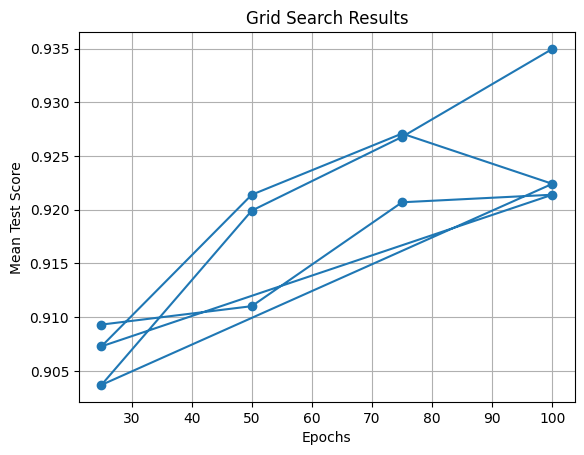

Best: 0.934966 using {'batch_size': 128, 'epochs': 100}
0.909311 with: {'batch_size': 32, 'epochs': 25}
0.911025 with: {'batch_size': 32, 'epochs': 50}
0.920695 with: {'batch_size': 32, 'epochs': 75}
0.921398 with: {'batch_size': 32, 'epochs': 100}
0.907284 with: {'batch_size': 64, 'epochs': 25}
0.921396 with: {'batch_size': 64, 'epochs': 50}
0.927090 with: {'batch_size': 64, 'epochs': 75}
0.922411 with: {'batch_size': 64, 'epochs': 100}
0.903697 with: {'batch_size': 128, 'epochs': 25}
0.919916 with: {'batch_size': 128, 'epochs': 50}
0.926778 with: {'batch_size': 128, 'epochs': 75}
0.934966 with: {'batch_size': 128, 'epochs': 100}


In [24]:
# Wrap Keras model so it can be used by scikit-learn GridSearchCV
model = KerasClassifier(build_fn=create_cnn_attention_gru_model, verbose=0, input_shape=input_shape, num_classes=num_classes)

# Define the parameter grid to search through
param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [25, 50, 75, 100]
}

# Create GridSearchCV instance
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Perform grid search
grid_result = grid.fit(X_train, y_train, callbacks=[EarlyStopping(patience=3)])

# Extracting mean test scores and parameters
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']

# Extracting epochs from parameters
epochs = [param['epochs'] for param in params]

# Plotting
plt.plot(epochs, means, marker='o')
plt.title('Grid Search Results')
plt.xlabel('Epochs')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.show()

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

In [23]:
# Fungsi untuk melakukan K-fold cross-validation
def k_fold_cross_validation(X, y, k=5, epochs=100, batch_size=128):
    # Inisialisasi KFold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Daftar untuk menyimpan model pada setiap fold
    models = []
    
    # Loop melalui setiap fold
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        print(f'Fold {fold}')
        
        # Split data menjadi data latih dan data validasi
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Inisialisasi model
        model = create_cnn_attention_gru_model(input_shape=input_shape, num_classes=num_classes)
        
        # Latih model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=2)
        
        plot_training_history(history)
        
        # Evaluasi model pada data validasi
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        print(f'Validation Accuracy: {accuracy}')
        
        # Tambahkan model ke dalam daftar
        models.append(model)
        
        print()
    
    return models


Fold 1
Epoch 1/100
81/81 - 21s - loss: 1.8193 - accuracy: 0.3398 - val_loss: 1.3771 - val_accuracy: 0.5021 - 21s/epoch - 261ms/step
Epoch 2/100
81/81 - 14s - loss: 1.1308 - accuracy: 0.6115 - val_loss: 0.8855 - val_accuracy: 0.7010 - 14s/epoch - 178ms/step
Epoch 3/100
81/81 - 14s - loss: 0.8831 - accuracy: 0.7015 - val_loss: 0.8705 - val_accuracy: 0.6979 - 14s/epoch - 175ms/step
Epoch 4/100
81/81 - 15s - loss: 0.8214 - accuracy: 0.7267 - val_loss: 0.6969 - val_accuracy: 0.7708 - 15s/epoch - 180ms/step
Epoch 5/100
81/81 - 14s - loss: 0.6525 - accuracy: 0.7859 - val_loss: 0.7172 - val_accuracy: 0.7684 - 14s/epoch - 176ms/step
Epoch 6/100
81/81 - 14s - loss: 0.5963 - accuracy: 0.8068 - val_loss: 0.6135 - val_accuracy: 0.7988 - 14s/epoch - 176ms/step
Epoch 7/100
81/81 - 15s - loss: 0.5222 - accuracy: 0.8299 - val_loss: 0.5992 - val_accuracy: 0.7981 - 15s/epoch - 180ms/step
Epoch 8/100
81/81 - 15s - loss: 0.5330 - accuracy: 0.8231 - val_loss: 0.5427 - val_accuracy: 0.8187 - 15s/epoch - 189m

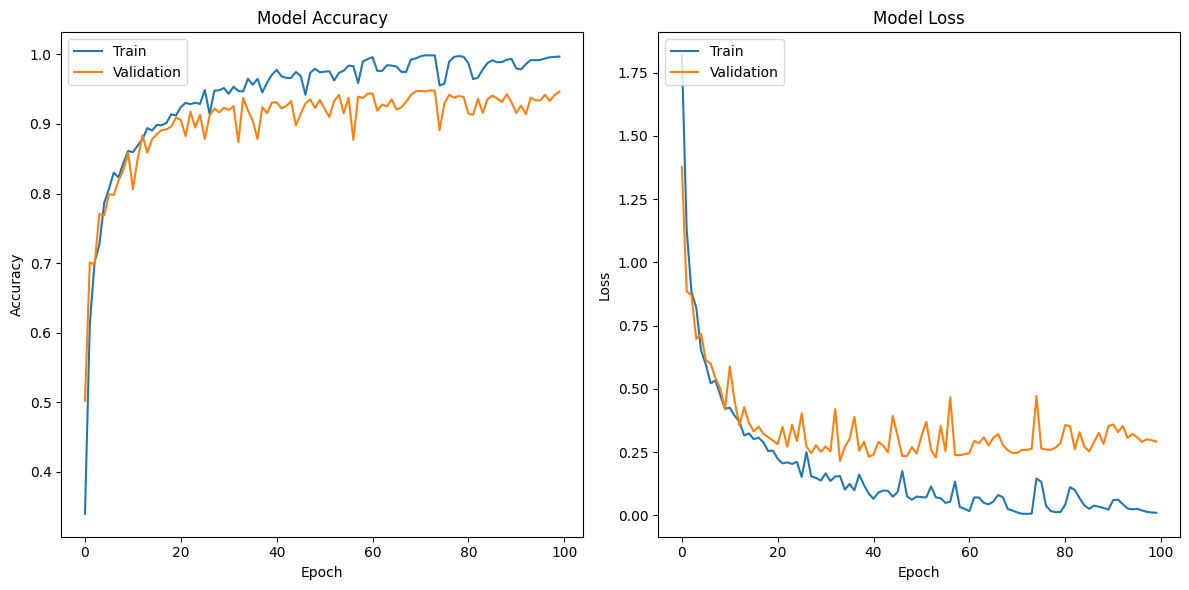

Validation Accuracy: 0.9465886950492859

Fold 2
Epoch 1/100
81/81 - 21s - loss: 1.8183 - accuracy: 0.3388 - val_loss: 1.4455 - val_accuracy: 0.4713 - 21s/epoch - 263ms/step
Epoch 2/100
81/81 - 14s - loss: 1.2306 - accuracy: 0.5624 - val_loss: 1.0171 - val_accuracy: 0.6460 - 14s/epoch - 175ms/step
Epoch 3/100
81/81 - 14s - loss: 0.9701 - accuracy: 0.6646 - val_loss: 1.0309 - val_accuracy: 0.6499 - 14s/epoch - 172ms/step
Epoch 4/100
81/81 - 14s - loss: 0.8423 - accuracy: 0.7173 - val_loss: 0.7683 - val_accuracy: 0.7536 - 14s/epoch - 177ms/step
Epoch 5/100
81/81 - 14s - loss: 0.7369 - accuracy: 0.7563 - val_loss: 0.6866 - val_accuracy: 0.7754 - 14s/epoch - 176ms/step
Epoch 6/100
81/81 - 14s - loss: 0.6483 - accuracy: 0.7857 - val_loss: 0.6205 - val_accuracy: 0.7934 - 14s/epoch - 179ms/step
Epoch 7/100
81/81 - 14s - loss: 0.5800 - accuracy: 0.8050 - val_loss: 0.8604 - val_accuracy: 0.7407 - 14s/epoch - 173ms/step
Epoch 8/100
81/81 - 14s - loss: 0.5742 - accuracy: 0.8102 - val_loss: 0.5474 

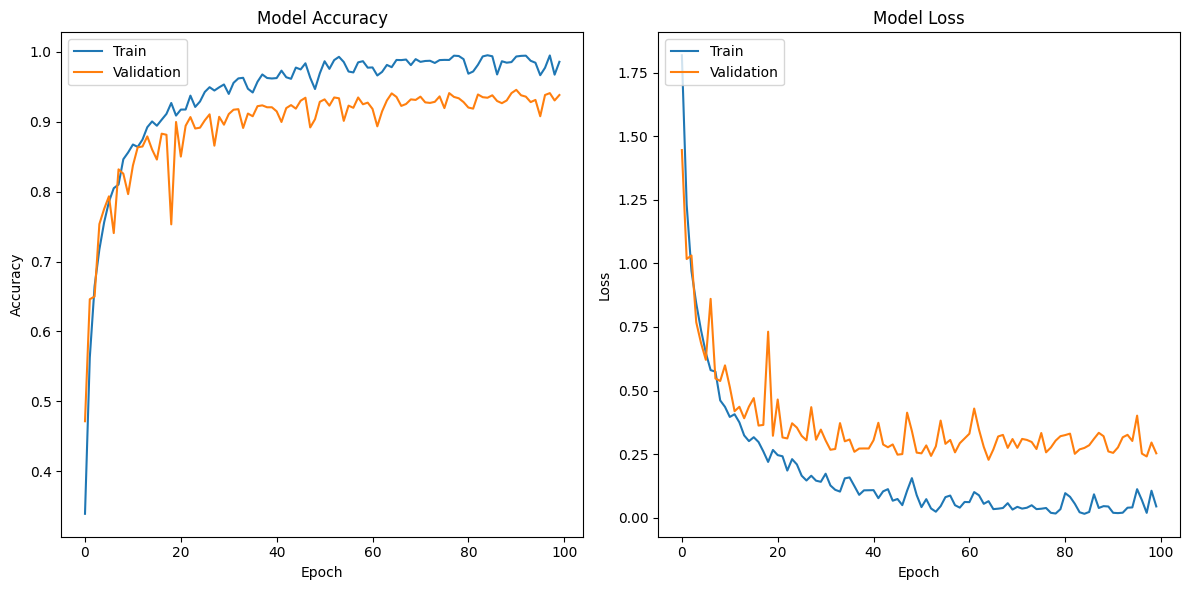

Validation Accuracy: 0.9384015798568726

Fold 3
Epoch 1/100
81/81 - 21s - loss: 1.8639 - accuracy: 0.3185 - val_loss: 1.3578 - val_accuracy: 0.5251 - 21s/epoch - 255ms/step
Epoch 2/100
81/81 - 14s - loss: 1.1809 - accuracy: 0.5908 - val_loss: 0.9668 - val_accuracy: 0.6581 - 14s/epoch - 175ms/step
Epoch 3/100
81/81 - 14s - loss: 0.9158 - accuracy: 0.6891 - val_loss: 0.8151 - val_accuracy: 0.7337 - 14s/epoch - 171ms/step
Epoch 4/100
81/81 - 14s - loss: 0.7403 - accuracy: 0.7553 - val_loss: 0.6728 - val_accuracy: 0.7918 - 14s/epoch - 171ms/step
Epoch 5/100
81/81 - 14s - loss: 0.6512 - accuracy: 0.7862 - val_loss: 0.6863 - val_accuracy: 0.7735 - 14s/epoch - 172ms/step
Epoch 6/100
81/81 - 14s - loss: 0.5815 - accuracy: 0.8094 - val_loss: 0.5603 - val_accuracy: 0.8133 - 14s/epoch - 177ms/step
Epoch 7/100
81/81 - 14s - loss: 0.5240 - accuracy: 0.8283 - val_loss: 0.6152 - val_accuracy: 0.7969 - 14s/epoch - 171ms/step
Epoch 8/100
81/81 - 14s - loss: 0.4938 - accuracy: 0.8353 - val_loss: 0.5089 

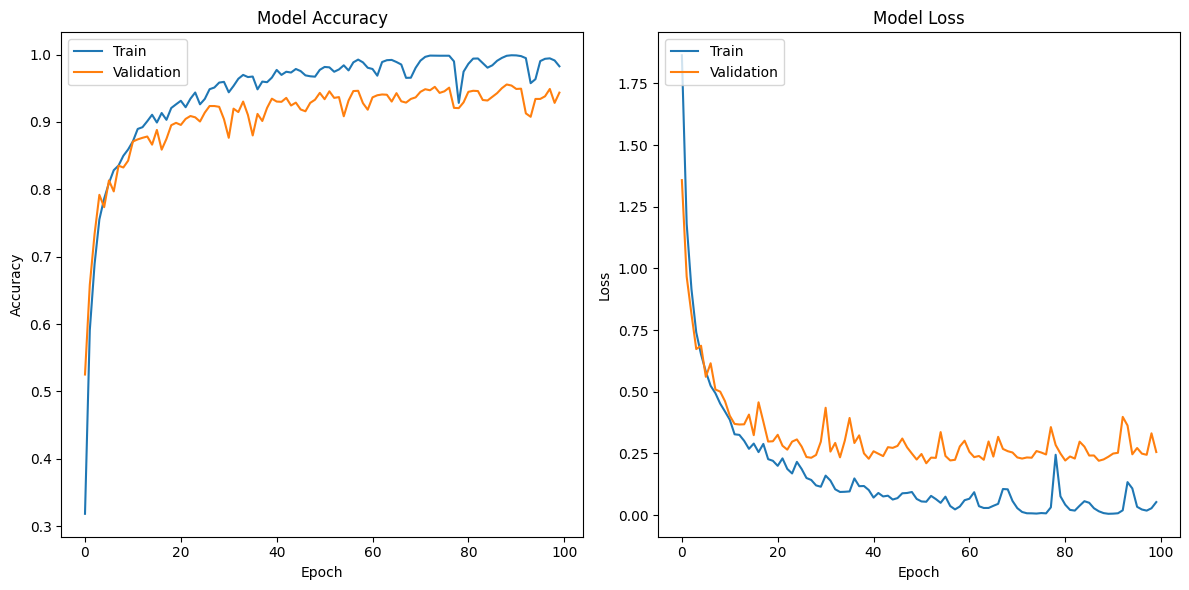

Validation Accuracy: 0.943469762802124

Fold 4
Epoch 1/100
81/81 - 21s - loss: 1.8121 - accuracy: 0.3415 - val_loss: 1.3992 - val_accuracy: 0.5111 - 21s/epoch - 255ms/step
Epoch 2/100
81/81 - 14s - loss: 1.2095 - accuracy: 0.5736 - val_loss: 1.0693 - val_accuracy: 0.6277 - 14s/epoch - 172ms/step
Epoch 3/100
81/81 - 14s - loss: 0.9516 - accuracy: 0.6758 - val_loss: 0.9289 - val_accuracy: 0.6811 - 14s/epoch - 170ms/step
Epoch 4/100
81/81 - 14s - loss: 0.7955 - accuracy: 0.7319 - val_loss: 0.7047 - val_accuracy: 0.7723 - 14s/epoch - 175ms/step
Epoch 5/100
81/81 - 14s - loss: 0.6453 - accuracy: 0.7859 - val_loss: 0.8888 - val_accuracy: 0.7158 - 14s/epoch - 168ms/step
Epoch 6/100
81/81 - 14s - loss: 0.5986 - accuracy: 0.8005 - val_loss: 0.6094 - val_accuracy: 0.7977 - 14s/epoch - 172ms/step
Epoch 7/100
81/81 - 14s - loss: 0.5265 - accuracy: 0.8227 - val_loss: 0.5798 - val_accuracy: 0.8062 - 14s/epoch - 170ms/step
Epoch 8/100
81/81 - 14s - loss: 0.4855 - accuracy: 0.8378 - val_loss: 0.6225 -

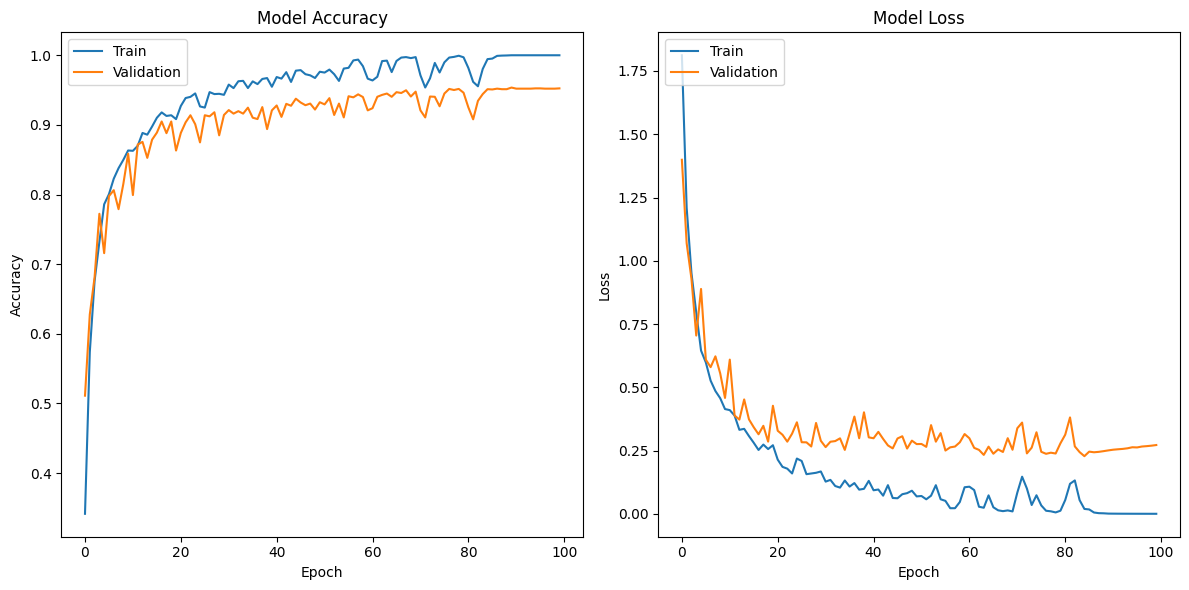

Validation Accuracy: 0.952436625957489

Fold 5
Epoch 1/100
81/81 - 21s - loss: 1.8496 - accuracy: 0.3151 - val_loss: 1.4452 - val_accuracy: 0.5101 - 21s/epoch - 256ms/step
Epoch 2/100
81/81 - 14s - loss: 1.2347 - accuracy: 0.5704 - val_loss: 0.9848 - val_accuracy: 0.6689 - 14s/epoch - 169ms/step
Epoch 3/100
81/81 - 14s - loss: 0.8574 - accuracy: 0.7190 - val_loss: 0.7755 - val_accuracy: 0.7484 - 14s/epoch - 169ms/step
Epoch 4/100
81/81 - 14s - loss: 0.7001 - accuracy: 0.7694 - val_loss: 0.6677 - val_accuracy: 0.7843 - 14s/epoch - 175ms/step
Epoch 5/100
81/81 - 14s - loss: 0.6523 - accuracy: 0.7900 - val_loss: 0.6891 - val_accuracy: 0.7796 - 14s/epoch - 168ms/step
Epoch 6/100
81/81 - 14s - loss: 0.5365 - accuracy: 0.8272 - val_loss: 0.5148 - val_accuracy: 0.8307 - 14s/epoch - 171ms/step
Epoch 7/100
81/81 - 14s - loss: 0.5090 - accuracy: 0.8306 - val_loss: 0.4780 - val_accuracy: 0.8436 - 14s/epoch - 169ms/step
Epoch 8/100
81/81 - 14s - loss: 0.4260 - accuracy: 0.8578 - val_loss: 0.5932 -

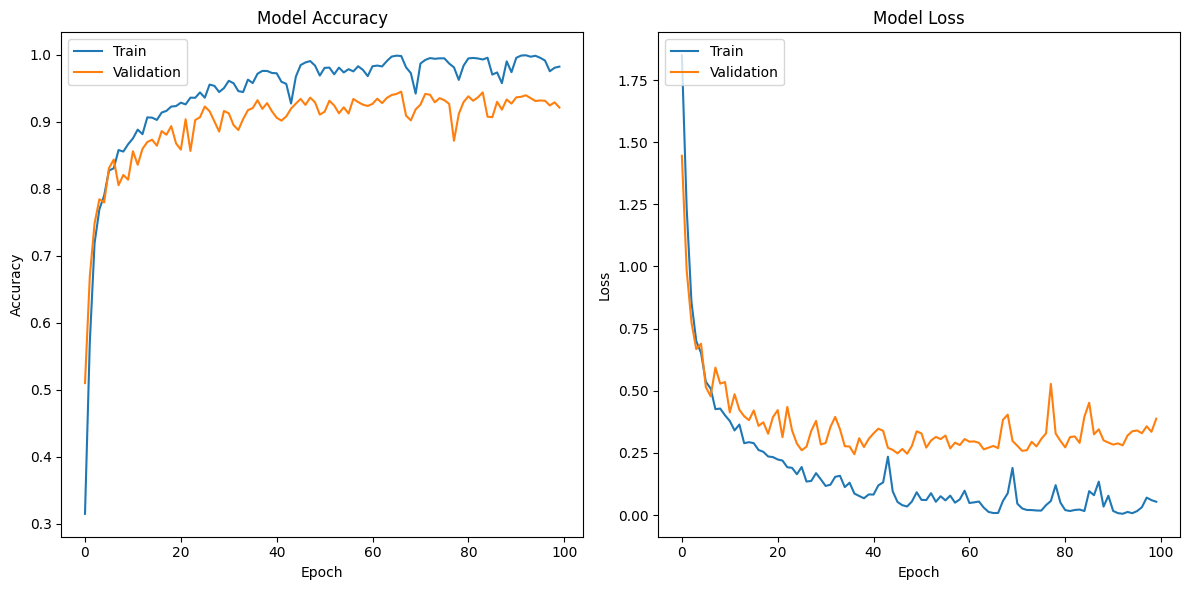

Validation Accuracy: 0.9212168455123901



In [24]:
cnn_attention_gru_tuning = k_fold_cross_validation(X_train, y_train)

model number:  1
101/101 [==============================] - 4s 25ms/step
Accuracy: 0.9448
Precision: 0.9444
Sensitivity (Recall): 0.9448
F1 Score: 0.9445
Confusion Matrix:
[[317   0   0   1   2   0   0   0   0   0]
 [  1 290   4   1  12   1   7   1   0   0]
 [  0   0 313   0   1   0   0   0   0   0]
 [  0   1   0 318   5   1   3   0   0   0]
 [  4   7   1   2 248  10  27   0   0   3]
 [  0   1   4   0   7 311   3   0   0   0]
 [  1   7   7   3  29   7 264   1   3   2]
 [  0   1   0   0   1   0   2 312   0   0]
 [  0   0   0   0   0   0   0   0 327   0]
 [  0   1   0   0   0   0   2   0   0 329]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       320
           1       0.94      0.91      0.93       317
           2       0.95      1.00      0.97       314
           3       0.98      0.97      0.97       328
           4       0.81      0.82      0.82       302
           5       0.94      0.95      0.95      

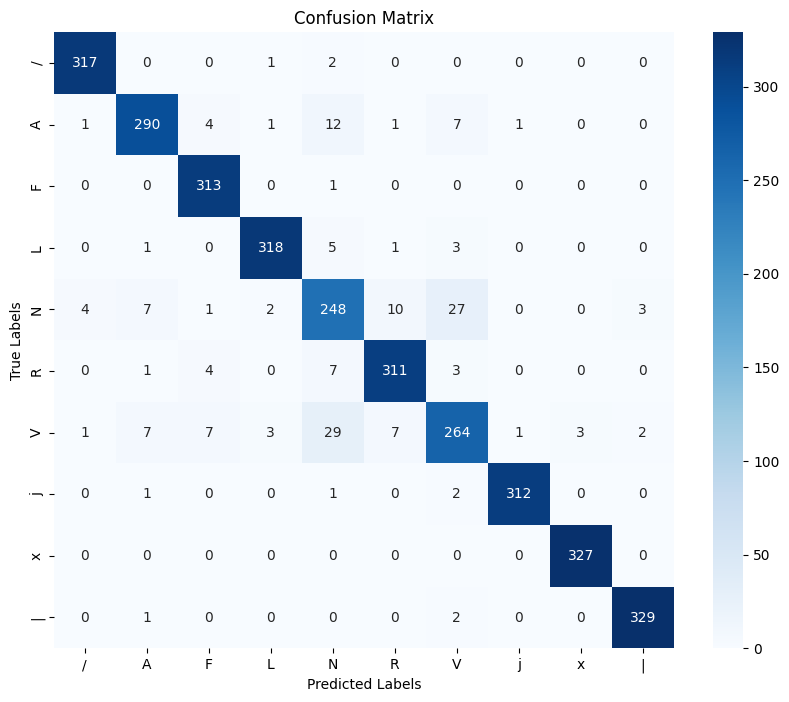

model number:  2
101/101 [==============================] - 3s 23ms/step
Accuracy: 0.9532
Precision: 0.9528
Sensitivity (Recall): 0.9532
F1 Score: 0.9529
Confusion Matrix:
[[320   0   0   0   0   0   0   0   0   0]
 [  2 297   1   2   6   1   8   0   0   0]
 [  0   0 313   0   1   0   0   0   0   0]
 [  1   0   0 315   8   2   2   0   0   0]
 [  1   8   2   2 255  11  17   0   0   6]
 [  0   2   0   1   5 306   9   1   0   2]
 [  2   9   2   0  24   4 277   0   1   5]
 [  0   1   0   0   0   0   0 315   0   0]
 [  0   0   0   0   0   0   1   0 326   0]
 [  0   0   0   0   0   0   0   0   0 332]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       320
           1       0.94      0.94      0.94       317
           2       0.98      1.00      0.99       314
           3       0.98      0.96      0.97       328
           4       0.85      0.84      0.85       302
           5       0.94      0.94      0.94      

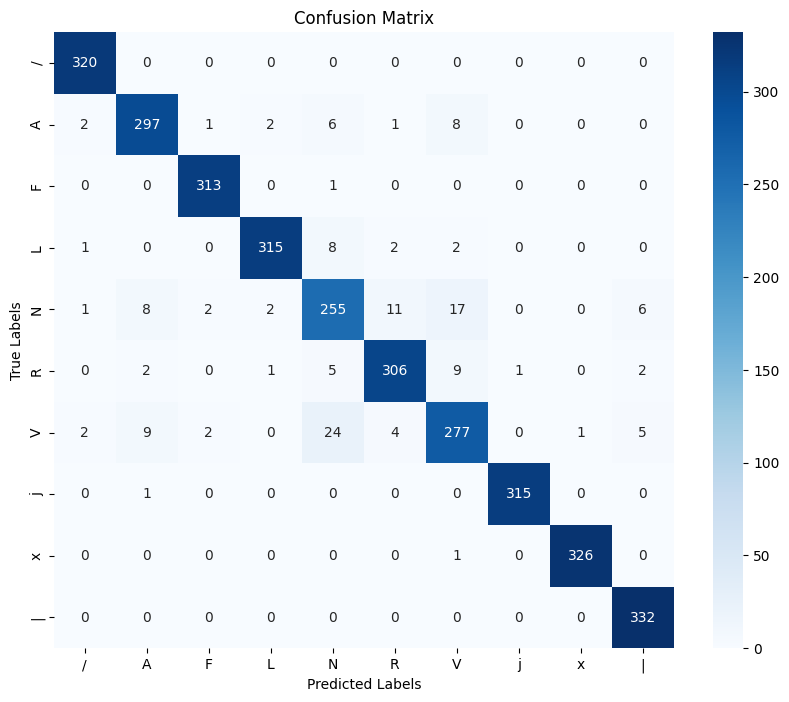

model number:  3
101/101 [==============================] - 3s 23ms/step
Accuracy: 0.9451
Precision: 0.9467
Sensitivity (Recall): 0.9451
F1 Score: 0.9449
Confusion Matrix:
[[318   0   0   0   2   0   0   0   0   0]
 [  0 304   1   0   7   1   3   1   0   0]
 [  0   1 309   0   4   0   0   0   0   0]
 [  3   1   0 322   1   0   0   0   0   1]
 [  3  11   1   7 258   6  15   0   0   1]
 [  0   0   1   1  20 296   4   0   0   4]
 [  0  14   6   3  45   3 250   0   0   3]
 [  0   0   0   0   0   0   0 316   0   0]
 [  0   0   0   0   0   0   1   0 326   0]
 [  0   1   0   0   0   0   0   0   0 331]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       320
           1       0.92      0.96      0.94       317
           2       0.97      0.98      0.98       314
           3       0.97      0.98      0.97       328
           4       0.77      0.85      0.81       302
           5       0.97      0.91      0.94      

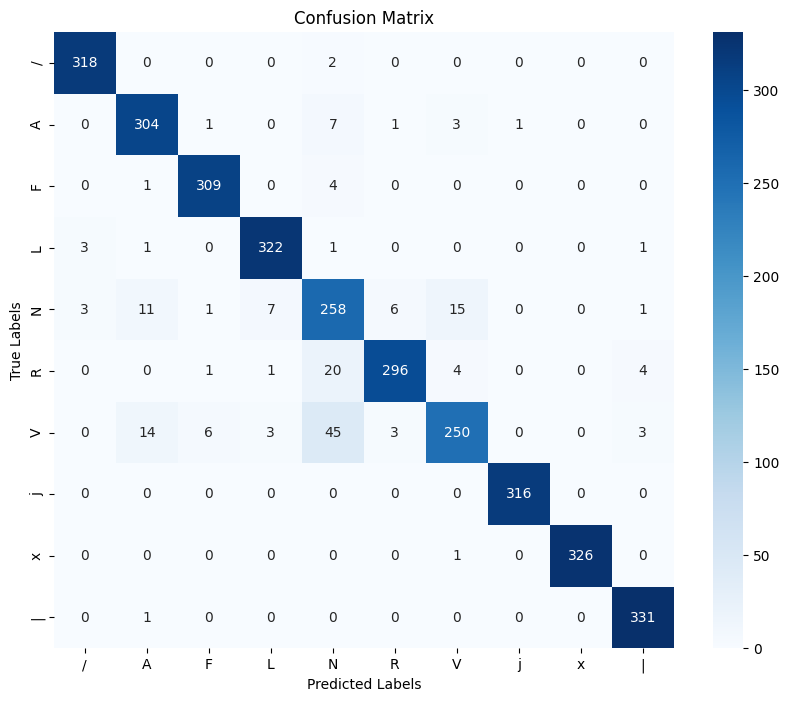

model number:  4
101/101 [==============================] - 3s 24ms/step
Accuracy: 0.9535
Precision: 0.9526
Sensitivity (Recall): 0.9535
F1 Score: 0.9528
Confusion Matrix:
[[317   0   0   2   1   0   0   0   0   0]
 [  0 306   1   0   3   1   5   1   0   0]
 [  0   0 314   0   0   0   0   0   0   0]
 [  0   0   0 319   7   0   1   0   0   1]
 [  2   9   0   3 237  18  29   1   0   3]
 [  0   1   0   0   7 313   5   0   0   0]
 [  1  12   4   3  19   4 276   0   1   4]
 [  0   0   0   0   0   0   0 316   0   0]
 [  0   0   0   0   0   0   0   0 327   0]
 [  0   0   0   0   0   0   0   0   0 332]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       320
           1       0.93      0.97      0.95       317
           2       0.98      1.00      0.99       314
           3       0.98      0.97      0.97       328
           4       0.86      0.78      0.82       302
           5       0.93      0.96      0.95      

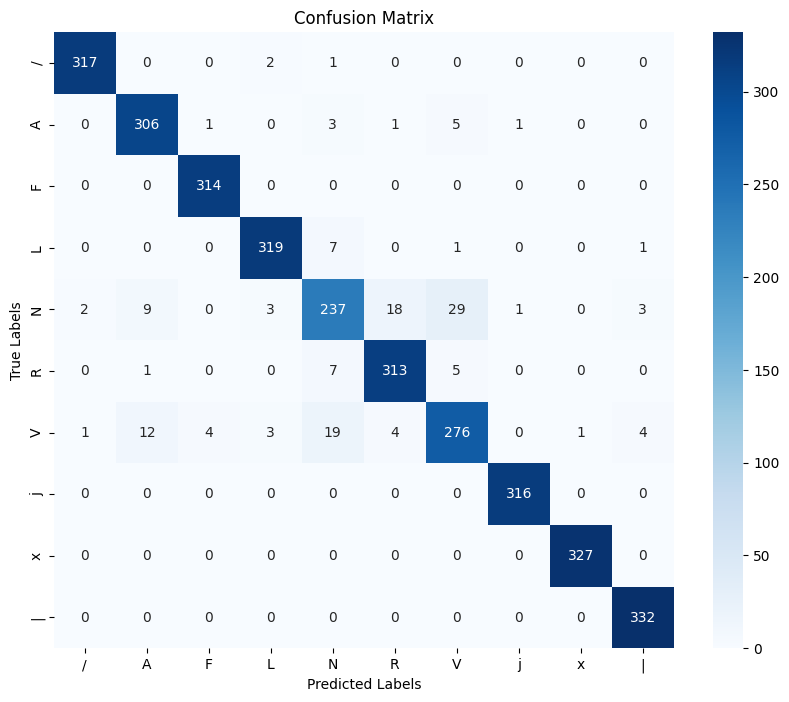

model number:  5
101/101 [==============================] - 4s 24ms/step
Accuracy: 0.9320
Precision: 0.9303
Sensitivity (Recall): 0.9320
F1 Score: 0.9303
Confusion Matrix:
[[316   0   0   3   0   0   1   0   0   0]
 [  0 283   8   5   6   4  10   0   1   0]
 [  0   0 314   0   0   0   0   0   0   0]
 [  2   0   0 319   4   1   2   0   0   0]
 [  3   8   3   7 221  17  35   1   3   4]
 [  0   2   1   0   6 303   8   1   4   1]
 [  0  10   6   9  18   7 257   1   9   7]
 [  0   0   0   0   0   0   0 316   0   0]
 [  0   0   0   0   0   0   0   0 327   0]
 [  0   0   0   0   0   0   0   0   0 332]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       320
           1       0.93      0.89      0.91       317
           2       0.95      1.00      0.97       314
           3       0.93      0.97      0.95       328
           4       0.87      0.73      0.79       302
           5       0.91      0.93      0.92      

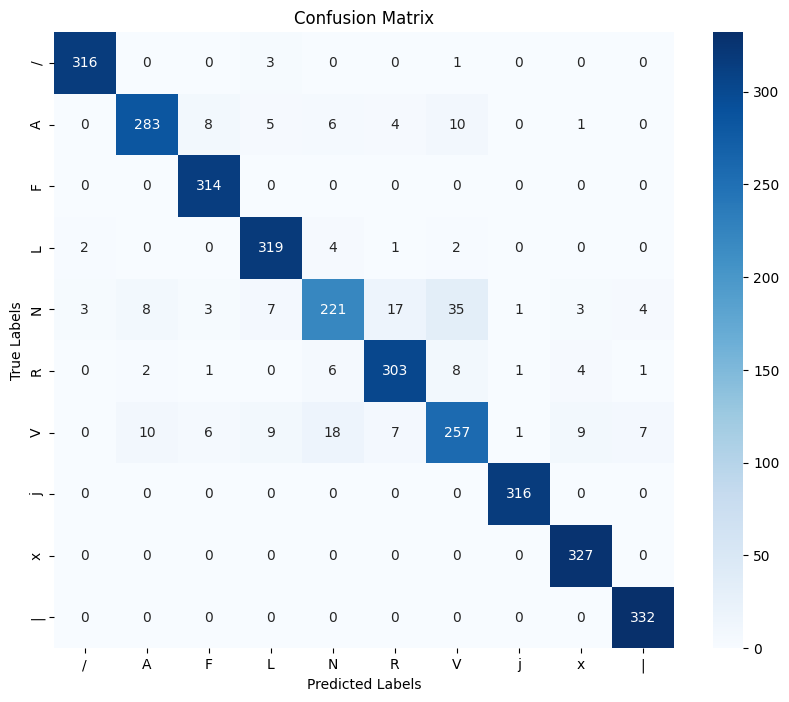

In [25]:
for i in range(5):
    print("model number: ", 1+i)
    y_pred = cnn_attention_gru_tuning[i].predict(X_test)
    y_pred_classes = y_pred.argmax(axis=-1)

    # Menghitung dan mencetak akurasi
    accuracy = accuracy_score(y_test, y_pred_classes)
    print(f'Accuracy: {accuracy:.4f}')

    # Menghitung dan mencetak precision
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    print(f'Precision: {precision:.4f}')

    # Menghitung dan mencetak sensitivity (recall)
    sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
    print(f'Sensitivity (Recall): {sensitivity:.4f}')

    # Menghitung dan mencetak F1 Score
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print(f'F1 Score: {f1:.4f}')

    # Menghitung dan mencetak confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    print('Confusion Matrix:')
    print(conf_matrix)

    # Menghitung dan mencetak classification report
    class_report = classification_report(y_test, y_pred_classes)
    print('Classification Report:')
    print(class_report)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [37]:
# Menghitung dan mencetak precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Menghitung dan mencetak sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Sensitivity (Recall): {sensitivity:.4f}')

# Menghitung dan mencetak F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9558
Sensitivity (Recall): 0.9566
F1 Score: 0.9559


In [26]:
with open("C:\\Users\\Administrator\\Documents\\my TA model\\cnn_attention_gru_list_tuning.pkl", "wb") as f:
    pickle.dump(cnn_attention_gru_tuning, f)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpeo878dao\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpeo878dao\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpra1apyef\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpra1apyef\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpaiqtshzw\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpaiqtshzw\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpjm4mc4vt\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpjm4mc4vt\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpg2741ynj\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpg2741ynj\assets


#2 CNN-LSTM

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` i

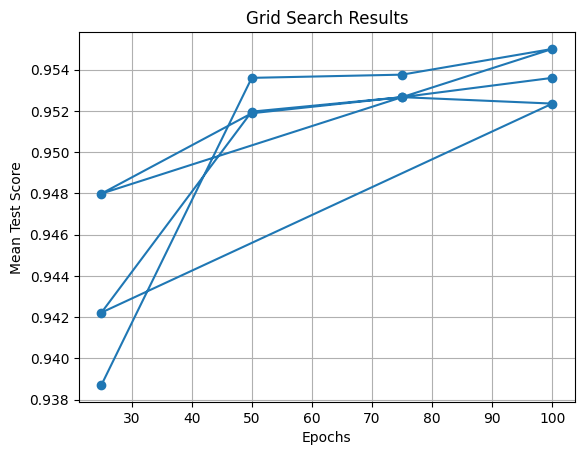

Best: 0.955006 using {'batch_size': 32, 'epochs': 100}
0.938708 with: {'batch_size': 32, 'epochs': 25}
0.953603 with: {'batch_size': 32, 'epochs': 50}
0.953759 with: {'batch_size': 32, 'epochs': 75}
0.955006 with: {'batch_size': 32, 'epochs': 100}
0.947988 with: {'batch_size': 64, 'epochs': 25}
0.951887 with: {'batch_size': 64, 'epochs': 50}
0.952667 with: {'batch_size': 64, 'epochs': 75}
0.952355 with: {'batch_size': 64, 'epochs': 100}
0.942218 with: {'batch_size': 128, 'epochs': 25}
0.951965 with: {'batch_size': 128, 'epochs': 50}
0.952667 with: {'batch_size': 128, 'epochs': 75}
0.953603 with: {'batch_size': 128, 'epochs': 100}


In [38]:
# Wrap Keras model so it can be used by scikit-learn GridSearchCV
model = KerasClassifier(build_fn=create_cnn_lstm_model, verbose=0, input_shape=input_shape, num_classes=num_classes)

# Define the parameter grid to search through
param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [25, 50, 75, 100]
}

# Create GridSearchCV instance
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Perform grid search
grid_result = grid.fit(X_train, y_train, callbacks=[EarlyStopping(patience=3)])

# Extracting mean test scores and parameters
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']

# Extracting epochs from parameters
epochs = [param['epochs'] for param in params]

# Plotting
plt.plot(epochs, means, marker='o')
plt.title('Grid Search Results')
plt.xlabel('Epochs')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.show()

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

In [39]:
# Fungsi untuk melakukan K-fold cross-validation
def k_fold_cross_validation(X, y, k=5, epochs=100, batch_size=32):
    # Inisialisasi KFold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Daftar untuk menyimpan model pada setiap fold
    models = []
    
    # Loop melalui setiap fold
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        print(f'Fold {fold}')
        
        # Split data menjadi data latih dan data validasi
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Inisialisasi model
        model = create_cnn_lstm_model(input_shape=input_shape, num_classes=num_classes)
        
        # Latih model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=2)
        
        plot_training_history(history)
        
        # Evaluasi model pada data validasi
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        print(f'Validation Accuracy: {accuracy}')
        
        # Tambahkan model ke dalam daftar
        models.append(model)
        
        print()
    
    return models


Fold 1
Epoch 1/100
321/321 - 26s - loss: 1.1670 - accuracy: 0.6274 - val_loss: 1.8141 - val_accuracy: 0.2359 - 26s/epoch - 80ms/step
Epoch 2/100
321/321 - 18s - loss: 0.7086 - accuracy: 0.7831 - val_loss: 0.4796 - val_accuracy: 0.8468 - 18s/epoch - 55ms/step
Epoch 3/100
321/321 - 20s - loss: 0.5727 - accuracy: 0.8280 - val_loss: 0.4024 - val_accuracy: 0.8756 - 20s/epoch - 62ms/step
Epoch 4/100
321/321 - 18s - loss: 0.4881 - accuracy: 0.8487 - val_loss: 0.3610 - val_accuracy: 0.8885 - 18s/epoch - 57ms/step
Epoch 5/100
321/321 - 17s - loss: 0.4267 - accuracy: 0.8703 - val_loss: 0.3475 - val_accuracy: 0.8877 - 17s/epoch - 52ms/step
Epoch 6/100
321/321 - 16s - loss: 0.3964 - accuracy: 0.8786 - val_loss: 0.2702 - val_accuracy: 0.9173 - 16s/epoch - 50ms/step
Epoch 7/100
321/321 - 16s - loss: 0.3492 - accuracy: 0.8954 - val_loss: 0.2921 - val_accuracy: 0.9049 - 16s/epoch - 49ms/step
Epoch 8/100
321/321 - 17s - loss: 0.3356 - accuracy: 0.8978 - val_loss: 0.2757 - val_accuracy: 0.9209 - 17s/epo

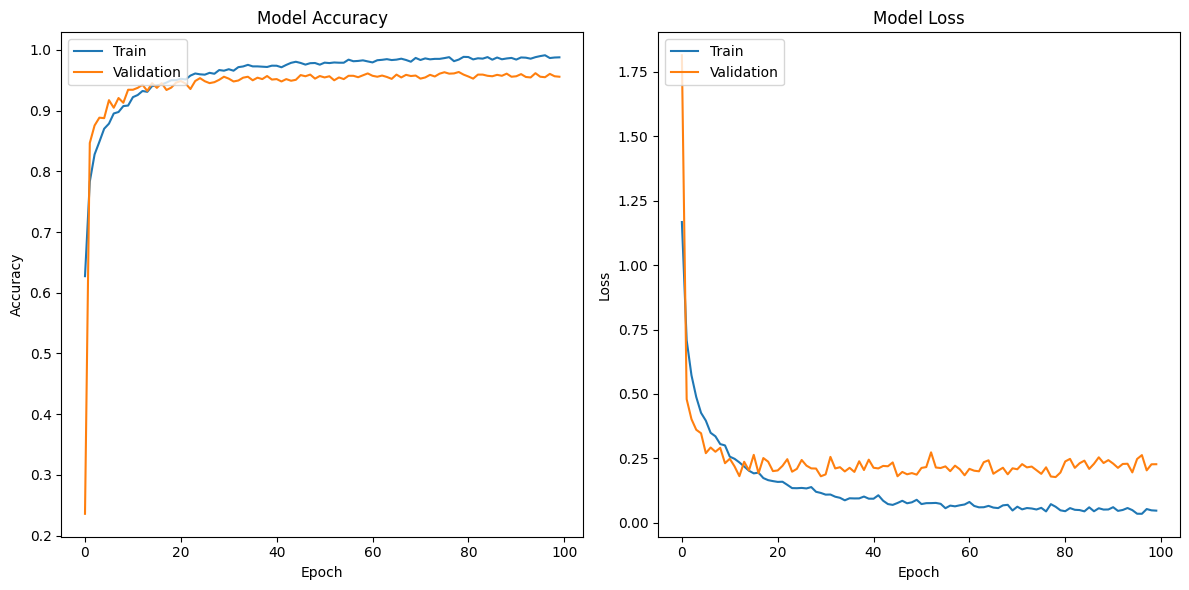

Validation Accuracy: 0.9559454321861267

Fold 2
Epoch 1/100
321/321 - 30s - loss: 1.1816 - accuracy: 0.6218 - val_loss: 1.7962 - val_accuracy: 0.2425 - 30s/epoch - 94ms/step
Epoch 2/100
321/321 - 18s - loss: 0.7123 - accuracy: 0.7797 - val_loss: 0.5899 - val_accuracy: 0.8269 - 18s/epoch - 55ms/step
Epoch 3/100
321/321 - 18s - loss: 0.5632 - accuracy: 0.8280 - val_loss: 0.4498 - val_accuracy: 0.8561 - 18s/epoch - 55ms/step
Epoch 4/100
321/321 - 18s - loss: 0.4657 - accuracy: 0.8564 - val_loss: 0.3770 - val_accuracy: 0.8850 - 18s/epoch - 55ms/step
Epoch 5/100
321/321 - 19s - loss: 0.4334 - accuracy: 0.8685 - val_loss: 0.3474 - val_accuracy: 0.8940 - 19s/epoch - 60ms/step
Epoch 6/100
321/321 - 18s - loss: 0.3771 - accuracy: 0.8890 - val_loss: 0.3751 - val_accuracy: 0.8932 - 18s/epoch - 57ms/step
Epoch 7/100
321/321 - 18s - loss: 0.3380 - accuracy: 0.8967 - val_loss: 0.3548 - val_accuracy: 0.9080 - 18s/epoch - 56ms/step
Epoch 8/100
321/321 - 18s - loss: 0.3062 - accuracy: 0.9094 - val_loss

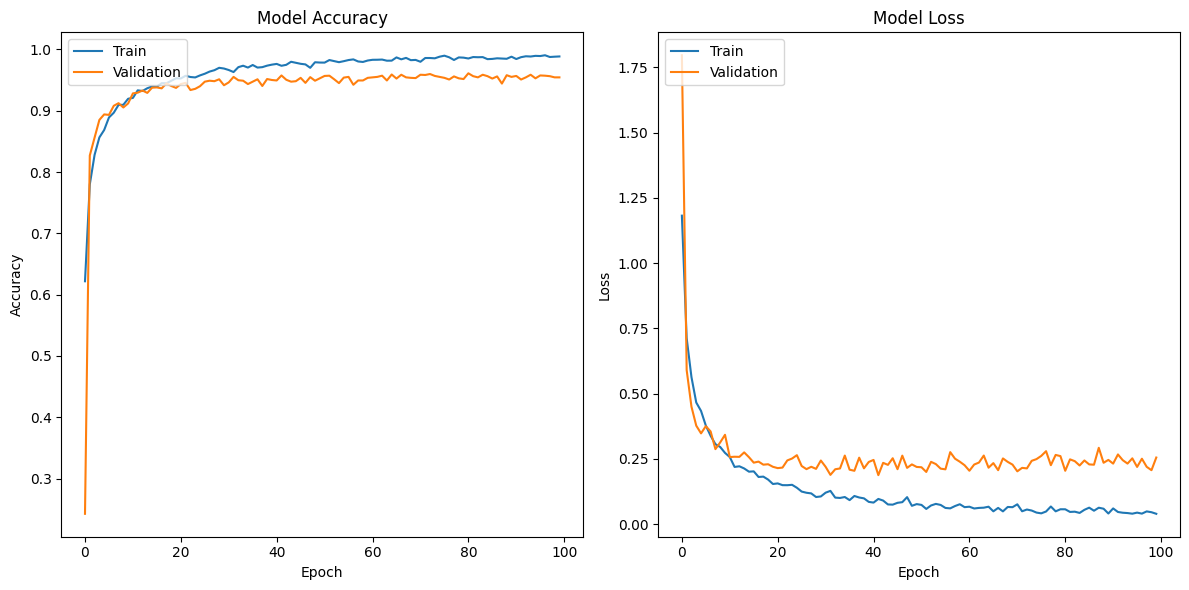

Validation Accuracy: 0.9543859362602234

Fold 3
Epoch 1/100
321/321 - 25s - loss: 1.1361 - accuracy: 0.6409 - val_loss: 1.7775 - val_accuracy: 0.3914 - 25s/epoch - 78ms/step
Epoch 2/100
321/321 - 15s - loss: 0.6944 - accuracy: 0.7883 - val_loss: 0.6167 - val_accuracy: 0.8113 - 15s/epoch - 47ms/step
Epoch 3/100
321/321 - 15s - loss: 0.5517 - accuracy: 0.8309 - val_loss: 0.3615 - val_accuracy: 0.8827 - 15s/epoch - 47ms/step
Epoch 4/100
321/321 - 15s - loss: 0.4875 - accuracy: 0.8517 - val_loss: 0.3196 - val_accuracy: 0.8924 - 15s/epoch - 46ms/step
Epoch 5/100
321/321 - 15s - loss: 0.4265 - accuracy: 0.8710 - val_loss: 0.3307 - val_accuracy: 0.8924 - 15s/epoch - 47ms/step
Epoch 6/100
321/321 - 15s - loss: 0.3699 - accuracy: 0.8828 - val_loss: 0.3150 - val_accuracy: 0.9010 - 15s/epoch - 46ms/step
Epoch 7/100
321/321 - 15s - loss: 0.3378 - accuracy: 0.8963 - val_loss: 0.2964 - val_accuracy: 0.9080 - 15s/epoch - 47ms/step
Epoch 8/100
321/321 - 15s - loss: 0.3068 - accuracy: 0.9047 - val_loss

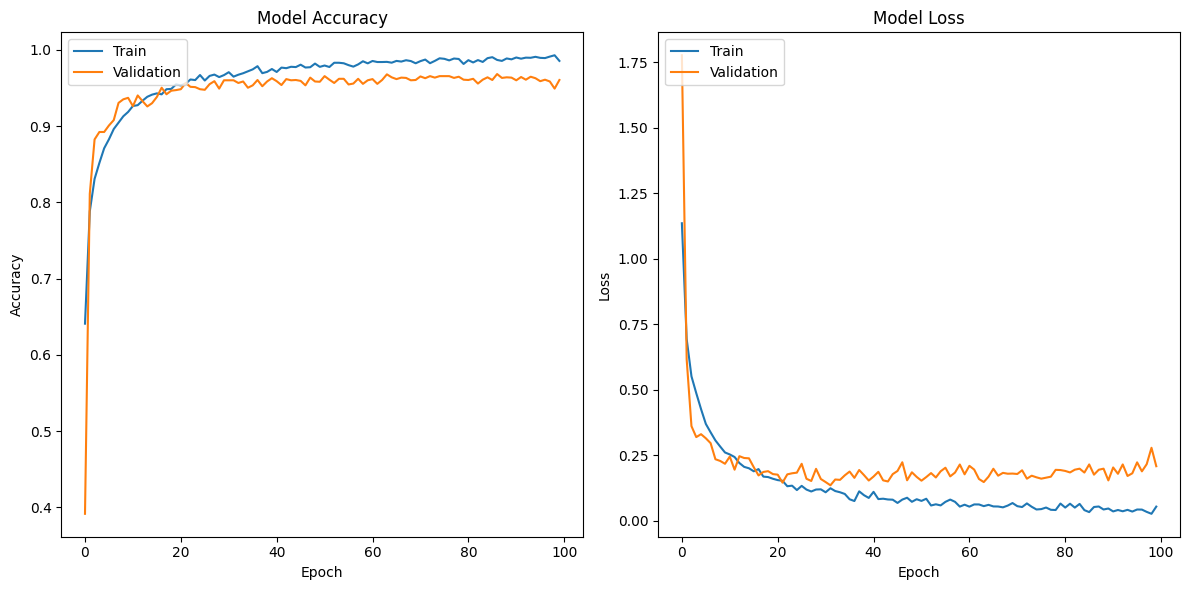

Validation Accuracy: 0.9606238007545471

Fold 4
Epoch 1/100
321/321 - 27s - loss: 1.1484 - accuracy: 0.6370 - val_loss: 1.8498 - val_accuracy: 0.1719 - 27s/epoch - 85ms/step
Epoch 2/100
321/321 - 19s - loss: 0.7037 - accuracy: 0.7857 - val_loss: 0.5586 - val_accuracy: 0.8246 - 19s/epoch - 59ms/step
Epoch 3/100
321/321 - 16s - loss: 0.5590 - accuracy: 0.8300 - val_loss: 0.4493 - val_accuracy: 0.8643 - 16s/epoch - 49ms/step
Epoch 4/100
321/321 - 16s - loss: 0.5042 - accuracy: 0.8463 - val_loss: 0.4077 - val_accuracy: 0.8752 - 16s/epoch - 49ms/step
Epoch 5/100
321/321 - 16s - loss: 0.4382 - accuracy: 0.8649 - val_loss: 0.3335 - val_accuracy: 0.8943 - 16s/epoch - 49ms/step
Epoch 6/100
321/321 - 16s - loss: 0.3969 - accuracy: 0.8787 - val_loss: 0.2799 - val_accuracy: 0.9080 - 16s/epoch - 49ms/step
Epoch 7/100
321/321 - 16s - loss: 0.3522 - accuracy: 0.8926 - val_loss: 0.2951 - val_accuracy: 0.9096 - 16s/epoch - 49ms/step
Epoch 8/100
321/321 - 16s - loss: 0.3383 - accuracy: 0.8956 - val_loss

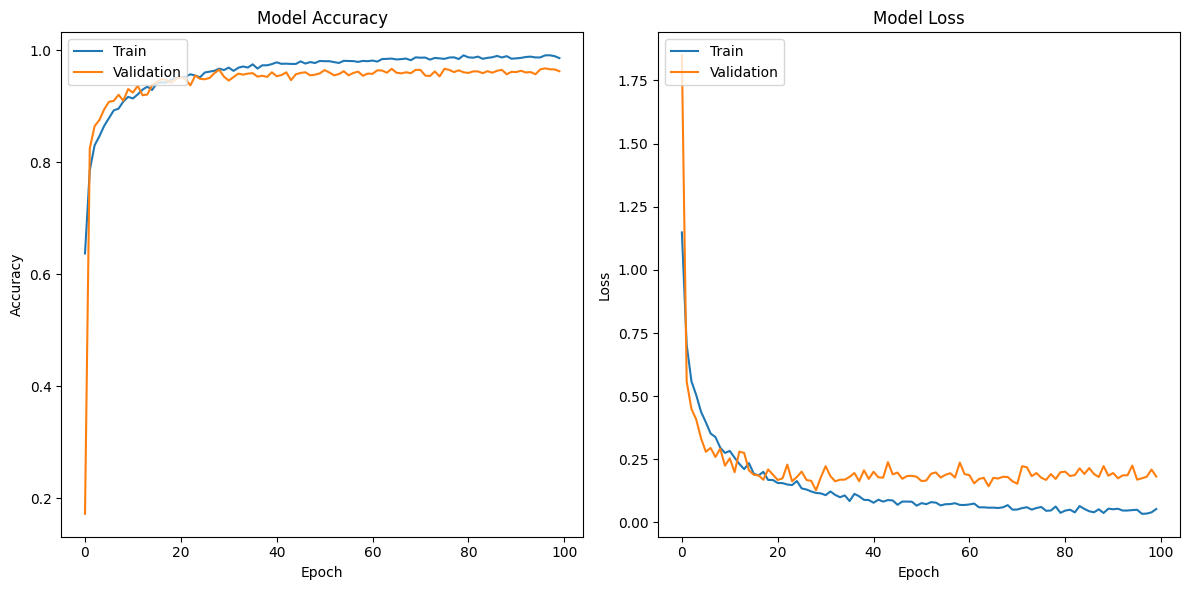

Validation Accuracy: 0.9625731110572815

Fold 5
Epoch 1/100
321/321 - 67s - loss: 1.1661 - accuracy: 0.6225 - val_loss: 1.8444 - val_accuracy: 0.2231 - 67s/epoch - 208ms/step
Epoch 2/100
321/321 - 17s - loss: 0.7138 - accuracy: 0.7799 - val_loss: 0.5918 - val_accuracy: 0.8085 - 17s/epoch - 52ms/step
Epoch 3/100
321/321 - 17s - loss: 0.5610 - accuracy: 0.8294 - val_loss: 0.4157 - val_accuracy: 0.8775 - 17s/epoch - 53ms/step
Epoch 4/100
321/321 - 17s - loss: 0.4841 - accuracy: 0.8548 - val_loss: 0.3205 - val_accuracy: 0.9005 - 17s/epoch - 53ms/step
Epoch 5/100
321/321 - 17s - loss: 0.4286 - accuracy: 0.8704 - val_loss: 0.3287 - val_accuracy: 0.8966 - 17s/epoch - 53ms/step
Epoch 6/100
321/321 - 17s - loss: 0.3921 - accuracy: 0.8804 - val_loss: 0.3280 - val_accuracy: 0.8959 - 17s/epoch - 53ms/step
Epoch 7/100
321/321 - 17s - loss: 0.3456 - accuracy: 0.8941 - val_loss: 0.3311 - val_accuracy: 0.8966 - 17s/epoch - 52ms/step
Epoch 8/100
321/321 - 17s - loss: 0.3034 - accuracy: 0.9078 - val_los

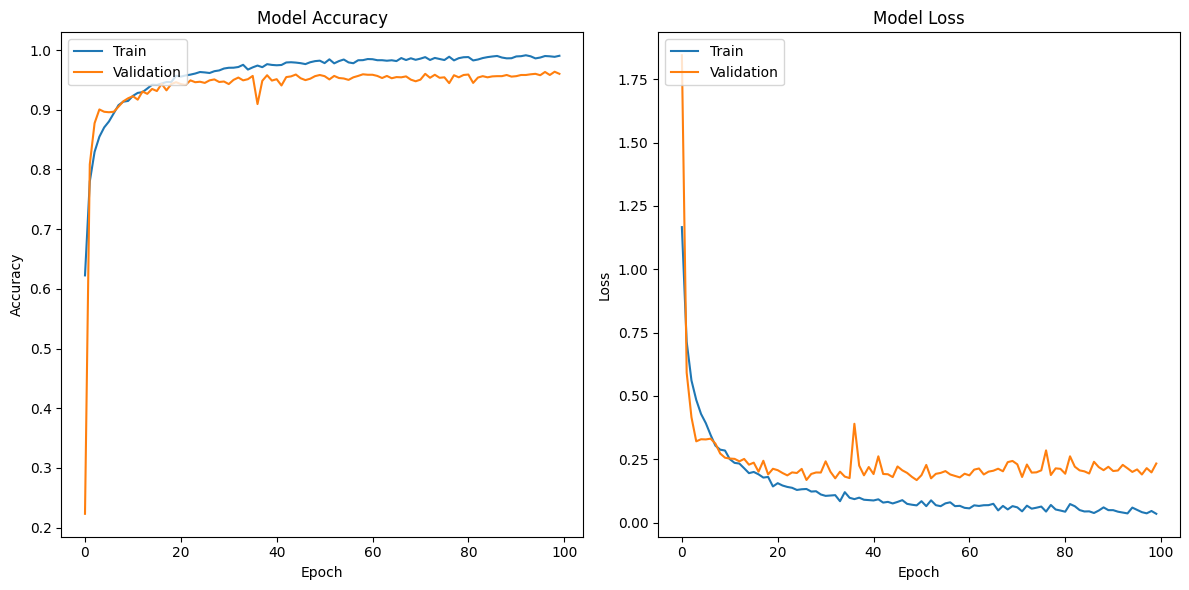

Validation Accuracy: 0.9602184295654297



In [40]:
cnn_lstm_tuning = k_fold_cross_validation(X_train, y_train)

101/101 [==============================] - 1s 12ms/step
Accuracy: 0.9682
Confusion Matrix:
[[318   1   0   1   0   0   0   0   0   0]
 [  0 313   2   0   0   0   2   0   0   0]
 [  0   0 314   0   0   0   0   0   0   0]
 [  3   1   0 318   6   0   0   0   0   0]
 [  3  11   3   0 260   5  16   0   0   4]
 [  0   0   0   0   4 322   0   0   0   0]
 [  0   4   7   1  18   3 284   1   2   4]
 [  0   0   0   0   0   0   0 316   0   0]
 [  0   0   0   0   0   0   0   0 327   0]
 [  0   0   0   0   0   0   0   0   0 332]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       320
           1       0.95      0.99      0.97       317
           2       0.96      1.00      0.98       314
           3       0.99      0.97      0.98       328
           4       0.90      0.86      0.88       302
           5       0.98      0.99      0.98       326
           6       0.94      0.88      0.91       324
           7       1.0

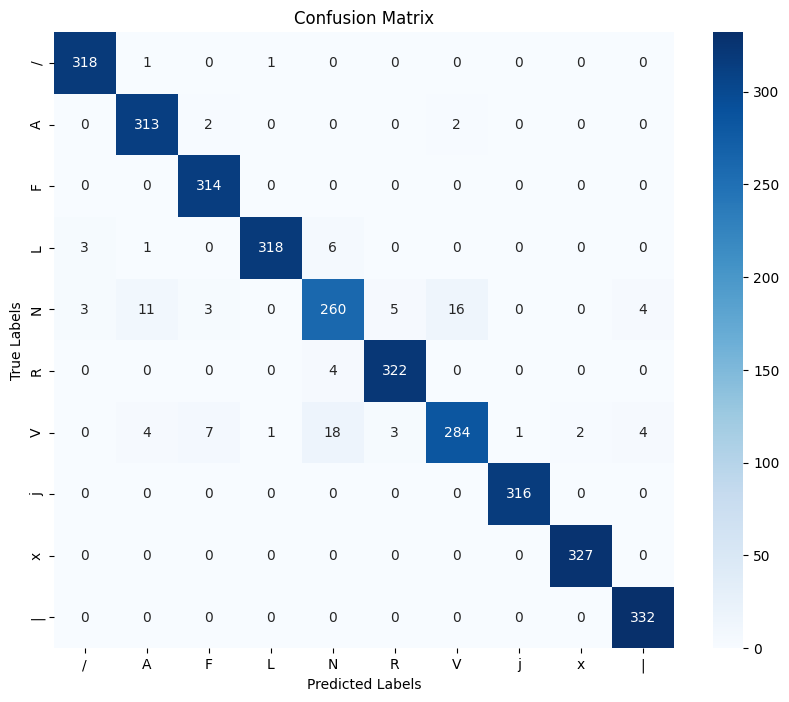

In [49]:
y_pred = cnn_lstm_tuning[3].predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Menghitung dan mencetak confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Menghitung dan mencetak classification report
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [50]:
# Menghitung dan mencetak precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Menghitung dan mencetak sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Sensitivity (Recall): {sensitivity:.4f}')

# Menghitung dan mencetak F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9678
Sensitivity (Recall): 0.9682
F1 Score: 0.9677


In [43]:
with open("C:\\Users\\Administrator\\Documents\\my TA model\\cnn_lstm_list_tuning.pkl", "wb") as f:
    pickle.dump(cnn_lstm_tuning, f)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpftagdlif\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpftagdlif\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmprflb9iz0\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmprflb9iz0\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpsjg3kjyy\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpsjg3kjyy\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpcopf4ebq\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpcopf4ebq\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpt8kpqfl6\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpt8kpqfl6\assets


#3 CNN-GRU

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` i

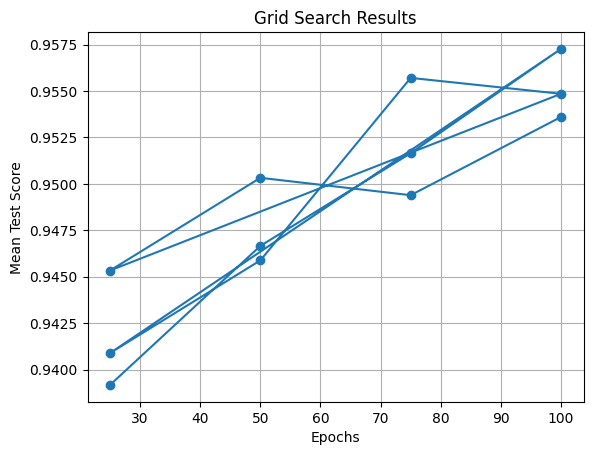

Best: 0.957268 using {'batch_size': 32, 'epochs': 100}
0.939177 with: {'batch_size': 32, 'epochs': 25}
0.946662 with: {'batch_size': 32, 'epochs': 50}
0.951653 with: {'batch_size': 32, 'epochs': 75}
0.957268 with: {'batch_size': 32, 'epochs': 100}
0.940892 with: {'batch_size': 64, 'epochs': 25}
0.945883 with: {'batch_size': 64, 'epochs': 50}
0.955708 with: {'batch_size': 64, 'epochs': 75}
0.954851 with: {'batch_size': 64, 'epochs': 100}
0.945337 with: {'batch_size': 128, 'epochs': 25}
0.950328 with: {'batch_size': 128, 'epochs': 50}
0.949392 with: {'batch_size': 128, 'epochs': 75}
0.953602 with: {'batch_size': 128, 'epochs': 100}


In [18]:
# Wrap Keras model so it can be used by scikit-learn GridSearchCV
model = KerasClassifier(build_fn=create_cnn_gru_model, verbose=0, input_shape=input_shape, num_classes=num_classes)

# Define the parameter grid to search through
param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [25, 50, 75, 100]
}

# Create GridSearchCV instance
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Perform grid search
grid_result = grid.fit(X_train, y_train, callbacks=[EarlyStopping(patience=3)])

# Extracting mean test scores and parameters
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']

# Extracting epochs from parameters
epochs = [param['epochs'] for param in params]

# Plotting
plt.plot(epochs, means, marker='o')
plt.title('Grid Search Results')
plt.xlabel('Epochs')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.show()

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

In [19]:
# Fungsi untuk melakukan K-fold cross-validation
def k_fold_cross_validation(X, y, k=5, epochs=100, batch_size=32):
    # Inisialisasi KFold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Daftar untuk menyimpan model pada setiap fold
    models = []
    
    # Loop melalui setiap fold
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        print(f'Fold {fold}')
        
        # Split data menjadi data latih dan data validasi
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Inisialisasi model
        model = create_cnn_gru_model(input_shape=input_shape, num_classes=num_classes)
        
        # Latih model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=2)
        
        plot_training_history(history)
        
        # Evaluasi model pada data validasi
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        print(f'Validation Accuracy: {accuracy}')
        
        # Tambahkan model ke dalam daftar
        models.append(model)
        
        print()
    
    return models


Fold 1
Epoch 1/100
321/321 - 29s - loss: 1.4006 - accuracy: 0.5532 - val_loss: 1.4915 - val_accuracy: 0.5131 - 29s/epoch - 89ms/step
Epoch 2/100
321/321 - 11s - loss: 0.8179 - accuracy: 0.7489 - val_loss: 0.5701 - val_accuracy: 0.8066 - 11s/epoch - 36ms/step
Epoch 3/100
321/321 - 11s - loss: 0.6564 - accuracy: 0.8036 - val_loss: 0.4422 - val_accuracy: 0.8608 - 11s/epoch - 35ms/step
Epoch 4/100
321/321 - 11s - loss: 0.5480 - accuracy: 0.8342 - val_loss: 0.3916 - val_accuracy: 0.8780 - 11s/epoch - 34ms/step
Epoch 5/100
321/321 - 11s - loss: 0.4722 - accuracy: 0.8586 - val_loss: 0.3103 - val_accuracy: 0.8955 - 11s/epoch - 35ms/step
Epoch 6/100
321/321 - 11s - loss: 0.4292 - accuracy: 0.8717 - val_loss: 0.3441 - val_accuracy: 0.8924 - 11s/epoch - 33ms/step
Epoch 7/100
321/321 - 11s - loss: 0.3609 - accuracy: 0.8930 - val_loss: 0.2565 - val_accuracy: 0.9158 - 11s/epoch - 34ms/step
Epoch 8/100
321/321 - 11s - loss: 0.3423 - accuracy: 0.8983 - val_loss: 0.3091 - val_accuracy: 0.9068 - 11s/epo

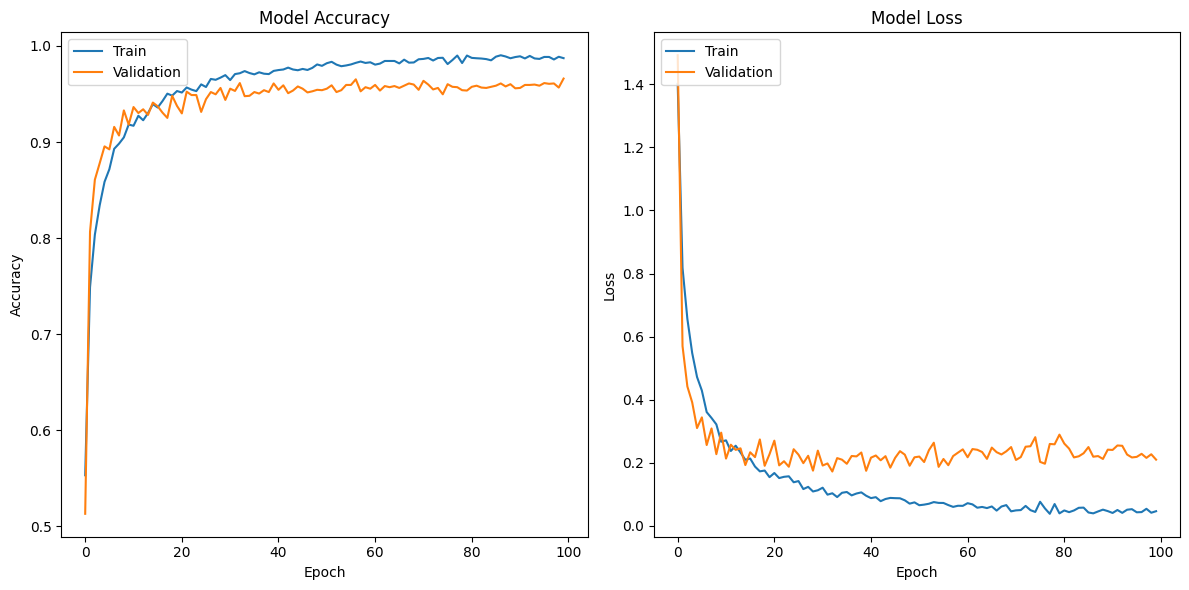

Validation Accuracy: 0.9660818576812744

Fold 2
Epoch 1/100
321/321 - 19s - loss: 1.4239 - accuracy: 0.5441 - val_loss: 1.3904 - val_accuracy: 0.5938 - 19s/epoch - 59ms/step
Epoch 2/100
321/321 - 10s - loss: 0.8399 - accuracy: 0.7417 - val_loss: 0.5272 - val_accuracy: 0.8409 - 10s/epoch - 31ms/step
Epoch 3/100
321/321 - 10s - loss: 0.6410 - accuracy: 0.8053 - val_loss: 0.4464 - val_accuracy: 0.8542 - 10s/epoch - 30ms/step
Epoch 4/100
321/321 - 10s - loss: 0.5401 - accuracy: 0.8349 - val_loss: 0.4090 - val_accuracy: 0.8827 - 10s/epoch - 30ms/step
Epoch 5/100
321/321 - 9s - loss: 0.4647 - accuracy: 0.8631 - val_loss: 0.3879 - val_accuracy: 0.8850 - 9s/epoch - 29ms/step
Epoch 6/100
321/321 - 9s - loss: 0.4031 - accuracy: 0.8797 - val_loss: 0.3545 - val_accuracy: 0.8897 - 9s/epoch - 30ms/step
Epoch 7/100
321/321 - 9s - loss: 0.3729 - accuracy: 0.8864 - val_loss: 0.3374 - val_accuracy: 0.8920 - 9s/epoch - 29ms/step
Epoch 8/100
321/321 - 10s - loss: 0.3468 - accuracy: 0.8934 - val_loss: 0.33

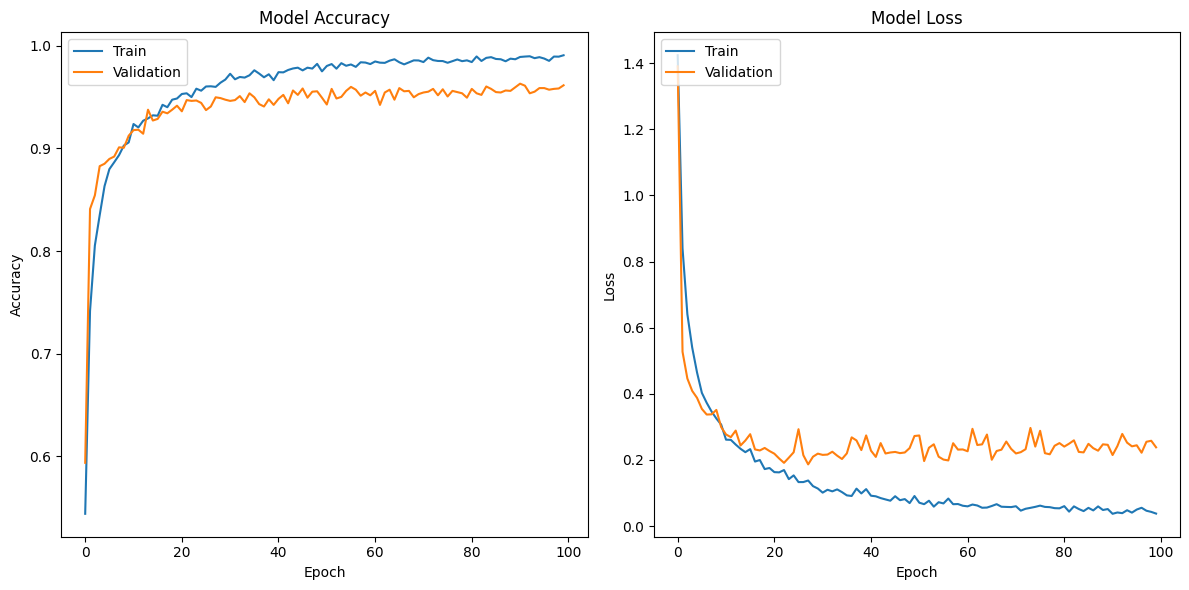

Validation Accuracy: 0.961403489112854

Fold 3
Epoch 1/100
321/321 - 18s - loss: 1.4276 - accuracy: 0.5494 - val_loss: 1.3190 - val_accuracy: 0.6639 - 18s/epoch - 55ms/step
Epoch 2/100
321/321 - 9s - loss: 0.8267 - accuracy: 0.7453 - val_loss: 0.6227 - val_accuracy: 0.8242 - 9s/epoch - 29ms/step
Epoch 3/100
321/321 - 9s - loss: 0.6441 - accuracy: 0.8050 - val_loss: 0.4578 - val_accuracy: 0.8526 - 9s/epoch - 29ms/step
Epoch 4/100
321/321 - 9s - loss: 0.5463 - accuracy: 0.8347 - val_loss: 0.3738 - val_accuracy: 0.8873 - 9s/epoch - 28ms/step
Epoch 5/100
321/321 - 9s - loss: 0.4670 - accuracy: 0.8584 - val_loss: 0.4055 - val_accuracy: 0.8776 - 9s/epoch - 29ms/step
Epoch 6/100
321/321 - 9s - loss: 0.4078 - accuracy: 0.8764 - val_loss: 0.3452 - val_accuracy: 0.8959 - 9s/epoch - 28ms/step
Epoch 7/100
321/321 - 9s - loss: 0.3874 - accuracy: 0.8804 - val_loss: 0.3630 - val_accuracy: 0.8873 - 9s/epoch - 28ms/step
Epoch 8/100
321/321 - 9s - loss: 0.3476 - accuracy: 0.8925 - val_loss: 0.2698 - val

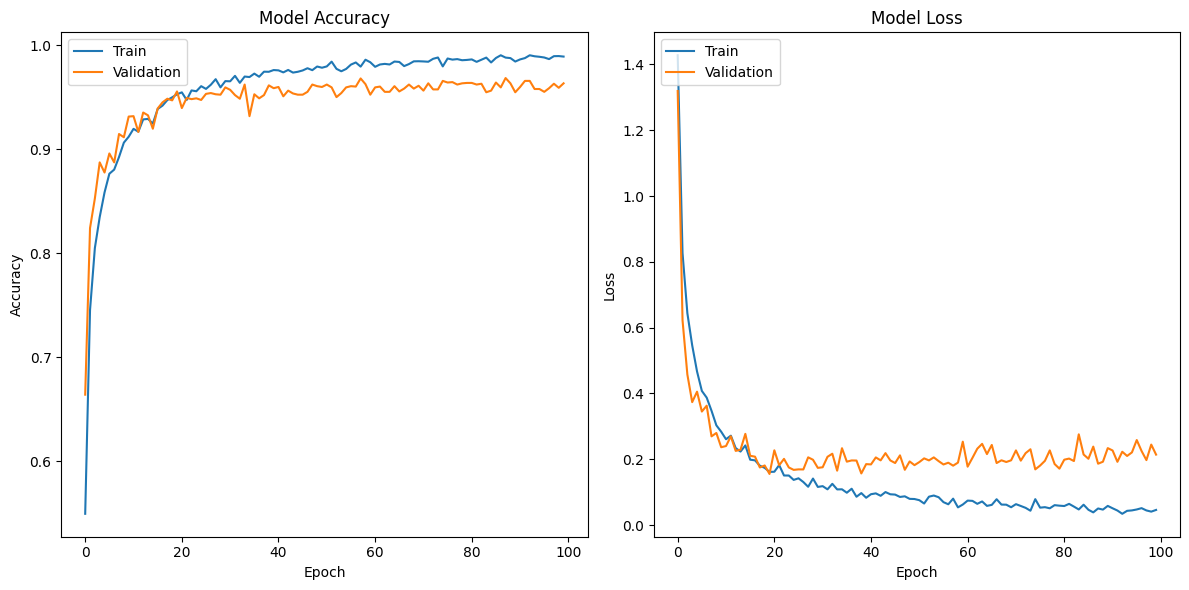

Validation Accuracy: 0.9633527994155884

Fold 4
Epoch 1/100
321/321 - 17s - loss: 1.4357 - accuracy: 0.5451 - val_loss: 1.2395 - val_accuracy: 0.7302 - 17s/epoch - 53ms/step
Epoch 2/100
321/321 - 9s - loss: 0.8367 - accuracy: 0.7423 - val_loss: 0.5991 - val_accuracy: 0.8140 - 9s/epoch - 29ms/step
Epoch 3/100
321/321 - 9s - loss: 0.6553 - accuracy: 0.8007 - val_loss: 0.4218 - val_accuracy: 0.8686 - 9s/epoch - 29ms/step
Epoch 4/100
321/321 - 9s - loss: 0.5355 - accuracy: 0.8381 - val_loss: 0.4082 - val_accuracy: 0.8671 - 9s/epoch - 28ms/step
Epoch 5/100
321/321 - 9s - loss: 0.4773 - accuracy: 0.8529 - val_loss: 0.3168 - val_accuracy: 0.9021 - 9s/epoch - 28ms/step
Epoch 6/100
321/321 - 9s - loss: 0.4059 - accuracy: 0.8764 - val_loss: 0.3578 - val_accuracy: 0.8975 - 9s/epoch - 28ms/step
Epoch 7/100
321/321 - 9s - loss: 0.3744 - accuracy: 0.8860 - val_loss: 0.2830 - val_accuracy: 0.9103 - 9s/epoch - 28ms/step
Epoch 8/100
321/321 - 9s - loss: 0.3386 - accuracy: 0.8991 - val_loss: 0.2653 - va

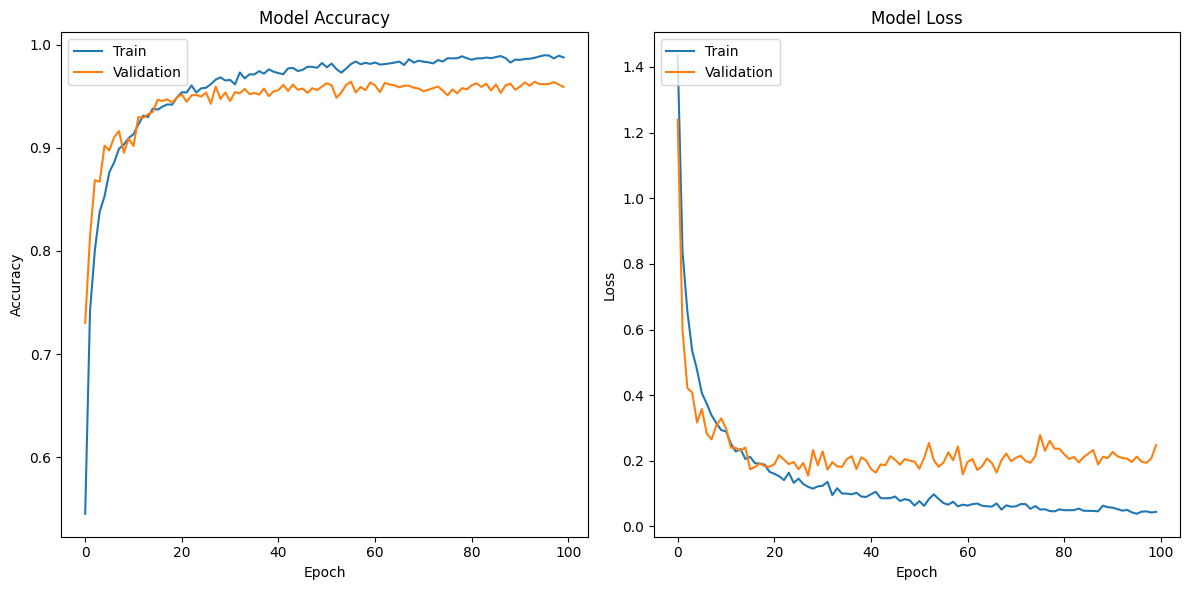

Validation Accuracy: 0.9590643048286438

Fold 5
Epoch 1/100
321/321 - 18s - loss: 1.4602 - accuracy: 0.5281 - val_loss: 1.3540 - val_accuracy: 0.6330 - 18s/epoch - 57ms/step
Epoch 2/100
321/321 - 9s - loss: 0.8535 - accuracy: 0.7394 - val_loss: 0.7492 - val_accuracy: 0.7964 - 9s/epoch - 28ms/step
Epoch 3/100
321/321 - 9s - loss: 0.6669 - accuracy: 0.7980 - val_loss: 0.4882 - val_accuracy: 0.8479 - 9s/epoch - 28ms/step
Epoch 4/100
321/321 - 9s - loss: 0.5557 - accuracy: 0.8321 - val_loss: 0.4061 - val_accuracy: 0.8775 - 9s/epoch - 29ms/step
Epoch 5/100
321/321 - 9s - loss: 0.4749 - accuracy: 0.8565 - val_loss: 0.3870 - val_accuracy: 0.8725 - 9s/epoch - 28ms/step
Epoch 6/100
321/321 - 9s - loss: 0.4229 - accuracy: 0.8739 - val_loss: 0.3499 - val_accuracy: 0.9033 - 9s/epoch - 28ms/step
Epoch 7/100
321/321 - 9s - loss: 0.3796 - accuracy: 0.8861 - val_loss: 0.3082 - val_accuracy: 0.9083 - 9s/epoch - 29ms/step
Epoch 8/100
321/321 - 9s - loss: 0.3516 - accuracy: 0.8938 - val_loss: 0.2963 - va

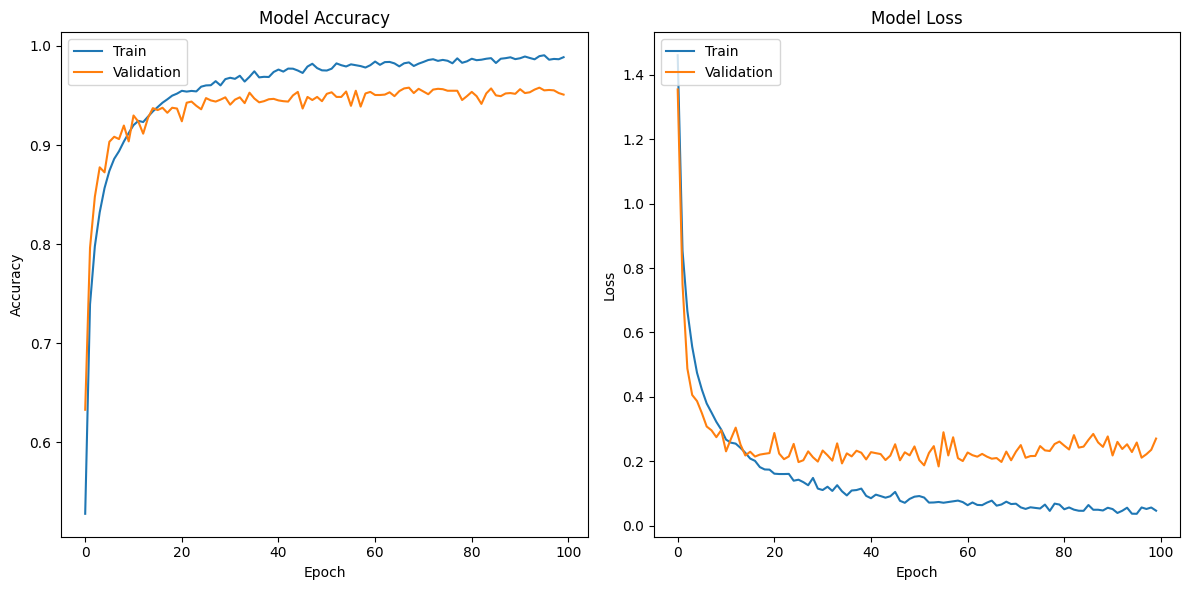

Validation Accuracy: 0.9508580565452576



In [22]:
cnn_gru_tuning = k_fold_cross_validation(X_train, y_train)

101/101 [==============================] - 1s 5ms/step
Accuracy: 0.9679
Confusion Matrix:
[[319   0   0   1   0   0   0   0   0   0]
 [  0 309   0   0   4   0   4   0   0   0]
 [  0   1 313   0   0   0   0   0   0   0]
 [  2   0   0 323   2   0   0   0   0   1]
 [  6   8   1   0 254   7  22   0   0   4]
 [  1   0   0   0   8 315   2   0   0   0]
 [  0   4   4   0  14   0 295   1   2   4]
 [  0   0   0   0   0   0   0 316   0   0]
 [  0   0   0   0   0   0   0   0 327   0]
 [  0   0   0   0   0   0   0   0   0 332]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       320
           1       0.96      0.97      0.97       317
           2       0.98      1.00      0.99       314
           3       1.00      0.98      0.99       328
           4       0.90      0.84      0.87       302
           5       0.98      0.97      0.97       326
           6       0.91      0.91      0.91       324
           7       1.00

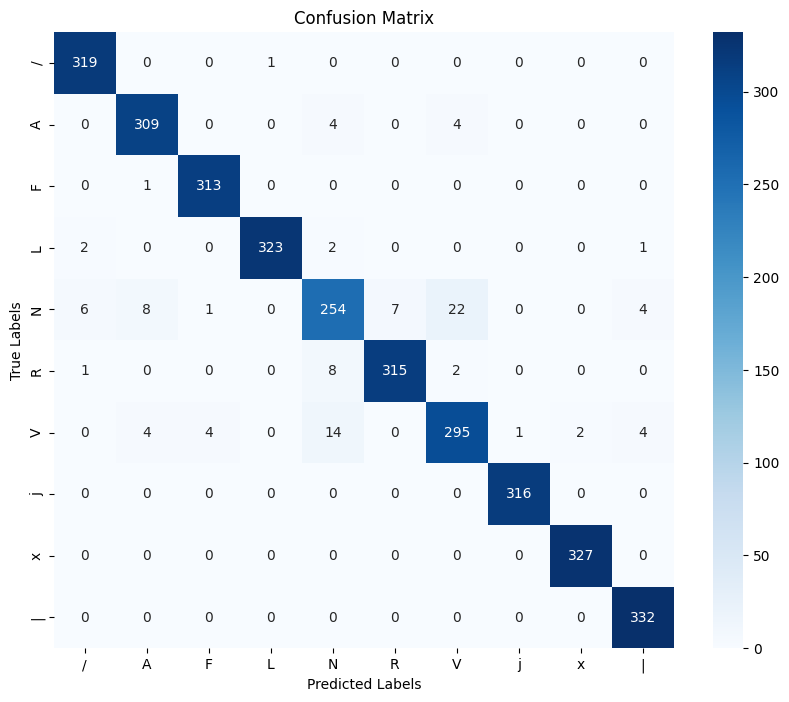

In [33]:
y_pred = cnn_gru_tuning[1].predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Menghitung dan mencetak confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Menghitung dan mencetak classification report
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Menghitung dan mencetak precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Menghitung dan mencetak sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Sensitivity (Recall): {sensitivity:.4f}')

# Menghitung dan mencetak F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9674
Sensitivity (Recall): 0.9679
F1 Score: 0.9675


In [23]:
with open("C:\\Users\\Administrator\\Documents\\my TA model\\cnn_gru_list_tuning.pkl", "wb") as f:
    pickle.dump(cnn_gru_tuning, f)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp0jjsh8jo\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp0jjsh8jo\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmprg94ep25\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmprg94ep25\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpr_k7yy3o\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpr_k7yy3o\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpd9iujybk\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpd9iujybk\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp8eklcuv5\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp8eklcuv5\assets
